In [2]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
# visualization
def show(tensor, ch=1, size=(28,28), num=16):
  data = tensor.detach().cpu().view(-1, ch, *size) # tensor: 128 x 784(28x28) -> 128 x 1 X 28 x 28 ; where batch size for example 128
  grid = make_grid(data[:num], nrow=4).permute(1,2,0) # 1 X 28 x 28 -> 28 X 28 X 1
  plt.imshow(grid)
  plt.show()

In [4]:
epochs = 20

current_step = 0
info_step = 100 # show the information
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # noise
lr = 0.00001
loss_fnc = nn.BCEWithLogitsLoss()

bs = 128
device = "cuda" if torch.cuda.is_available() else "cpu"

dataloader = DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),
                        batch_size=bs,
                        shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.30MB/s]


# Generator

In [5]:
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out), # 1d <- black and white image
      nn.ReLU(inplace=True) # replace data without allocating extra resources
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim = 128): # 28 x 28 = 784
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256, 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28,28)
        nn.Sigmoid()
    )

  def forward(self, noise):
    return self.gen(noise)

# Generate noise vector function
def gen_noise(num, z_dim):
  return torch.randn(num, z_dim).to(device)

# Discriminator

In [6]:
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=128):
    super().__init__()
    self.disc = nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
    return self.disc(image)

In [7]:
# instantiate
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [8]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [9]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 1, 2, 7, 0, 2, 7, 3, 6, 4])


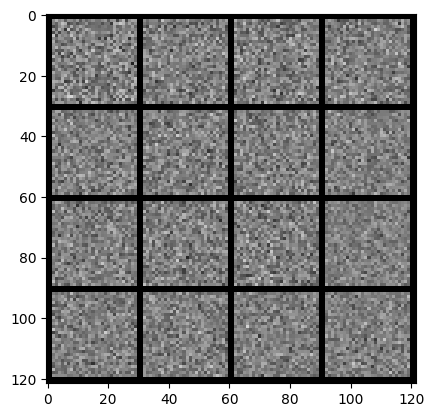

In [10]:
X, y = next(iter(dataloader))
print(X.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

# Calculating generator and discriminator loss

In [11]:
# generator loss
def calc_gen_loss(loss_fnc, gen, disc, num, z_dim):
  noise = gen_noise(num, z_dim)
  fake = gen(noise)
  pred = disc(fake)

  targets= torch.ones_like(pred) # make fool
  gen_loss =  loss_fnc(pred, targets)
  return gen_loss

# discriminator loss\
def calc_disc_loss(loss_fnc, gen, disc, num,  real, z_dim):
  noise = gen_noise(num, z_dim)
  fake = gen(noise)
  disc_fake = disc(fake.detach())

  disc_fake_targets = torch.zeros_like(disc_fake)
  disc_fake_loss = loss_fnc(disc_fake, disc_fake_targets)

  disc_real = disc(real)
  disc_real_targets = torch.ones_like(disc_real)
  disc_real_loss = loss_fnc(disc_real, disc_real_targets)

  disc_loss = (disc_fake_loss + disc_real_loss) / 2
  return disc_loss

# Training loop

  0%|          | 0/469 [00:00<?, ?it/s]

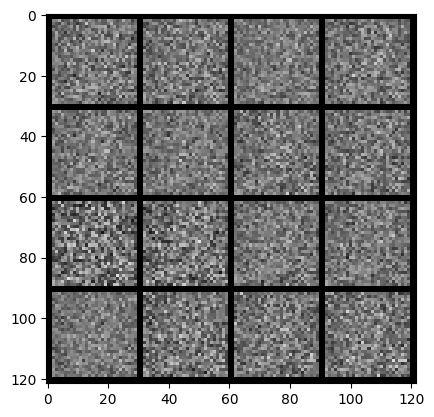

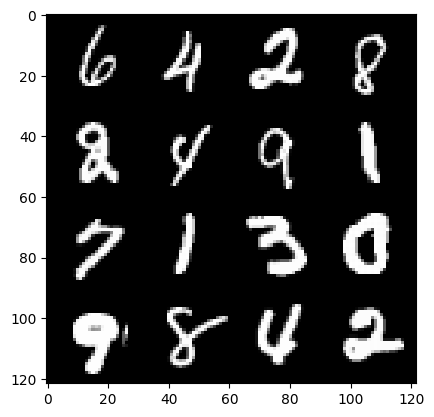

0: step: 100 | Gen loss: 0.8120771646499637 | Disc loss: 0.6499559402465821


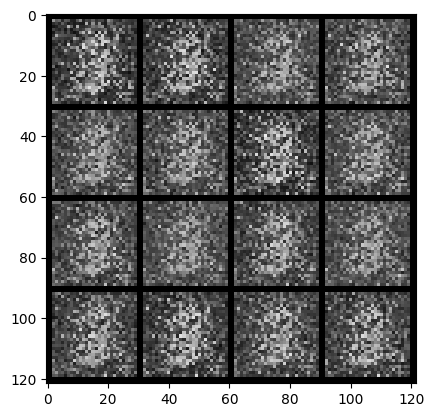

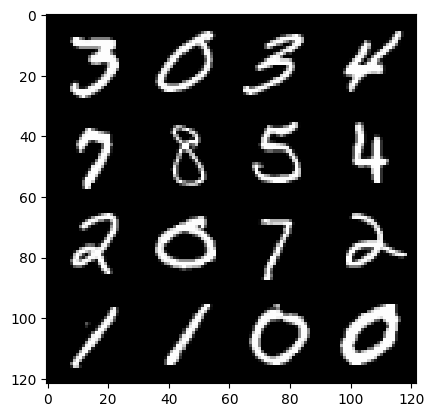

0: step: 200 | Gen loss: 1.1343419206142424 | Disc loss: 0.49207692235708245


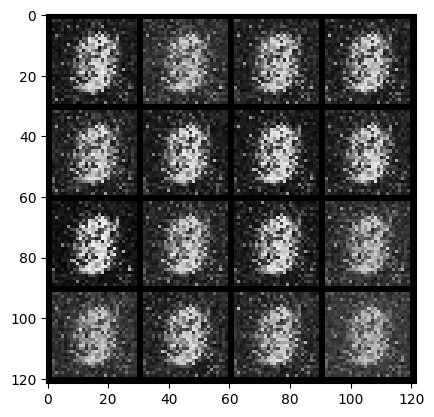

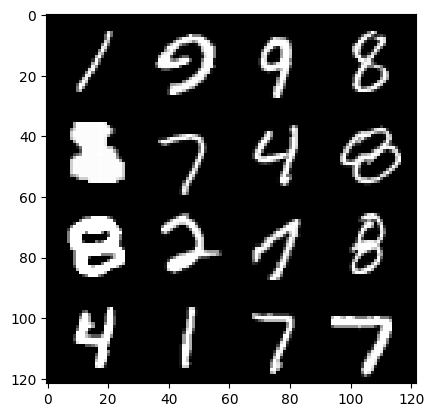

0: step: 300 | Gen loss: 1.5606785023212433 | Disc loss: 0.33292198270559303


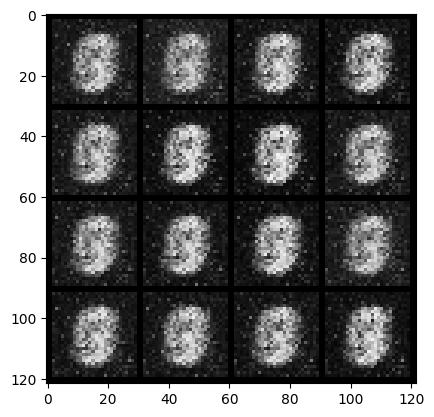

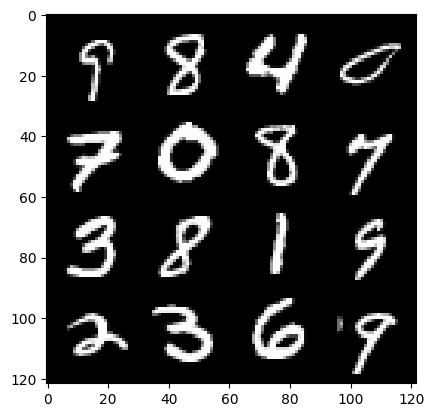

0: step: 400 | Gen loss: 1.8875071835517896 | Disc loss: 0.27787742376327507


  0%|          | 0/469 [00:00<?, ?it/s]

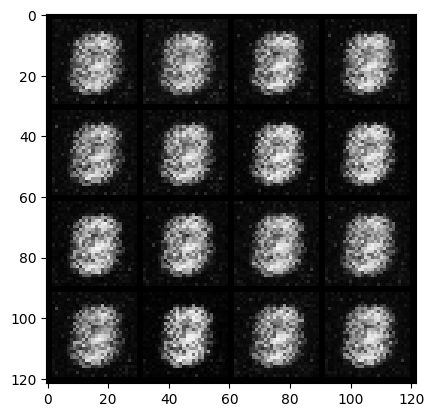

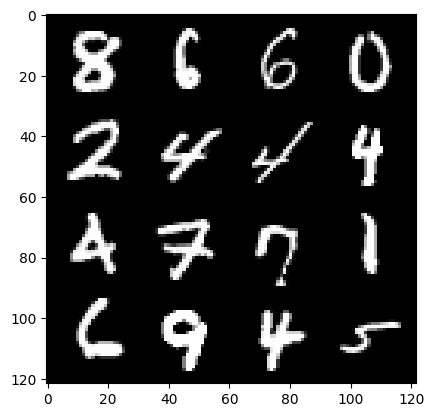

1: step: 500 | Gen loss: 1.8180984437465664 | Disc loss: 0.30515168309211727


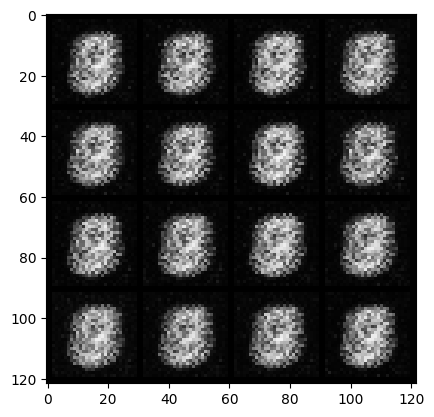

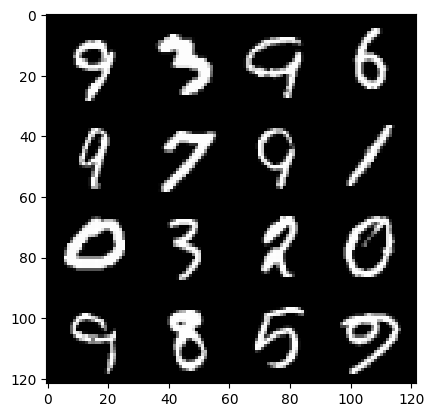

1: step: 600 | Gen loss: 1.6973438751697547 | Disc loss: 0.32183895319700223


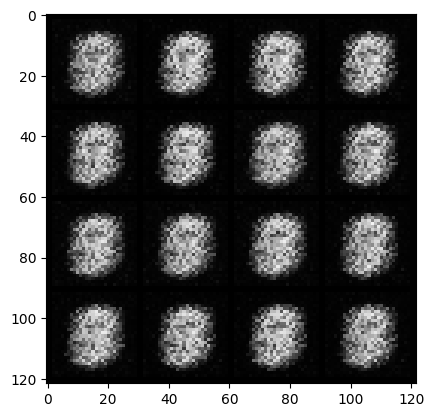

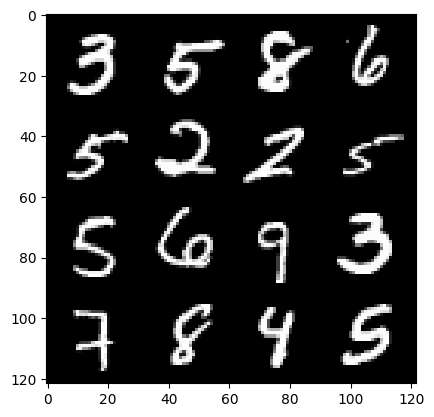

1: step: 700 | Gen loss: 1.7193872869014741 | Disc loss: 0.2993942281603813


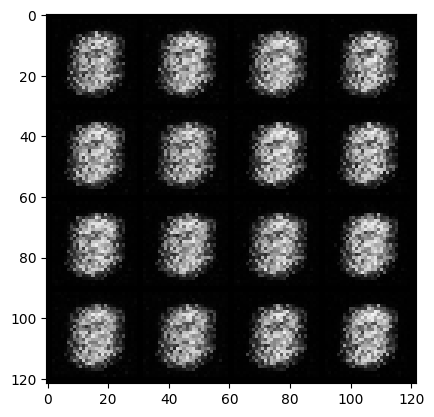

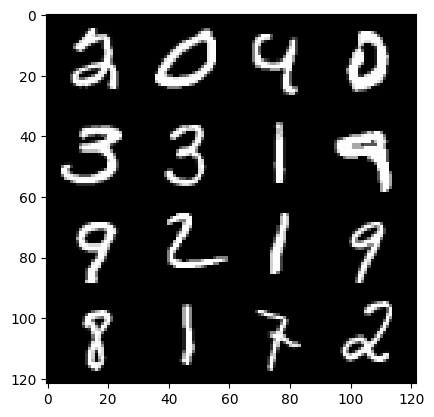

1: step: 800 | Gen loss: 1.8049625158309932 | Disc loss: 0.26313674822449684


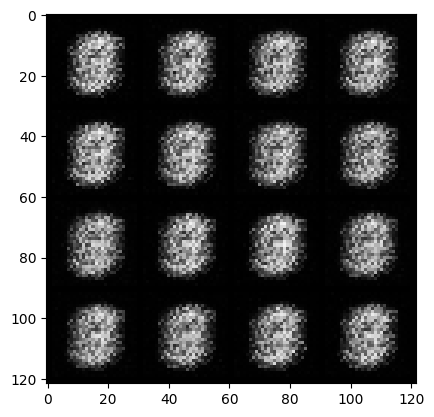

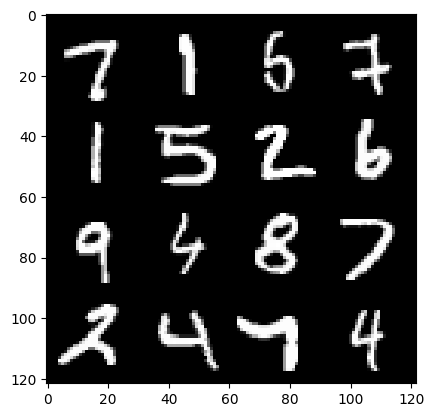

1: step: 900 | Gen loss: 1.9113577163219455 | Disc loss: 0.22234933257102973


  0%|          | 0/469 [00:00<?, ?it/s]

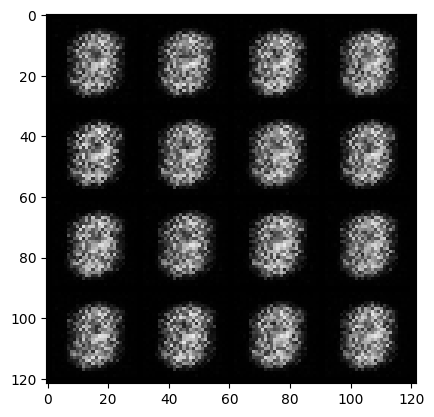

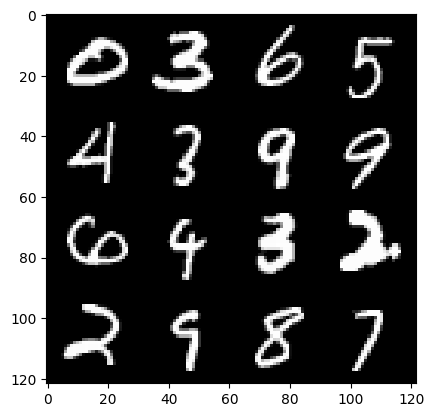

2: step: 1000 | Gen loss: 2.0144056713581087 | Disc loss: 0.1886918829381466


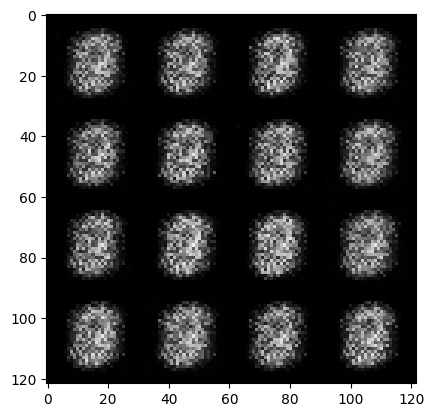

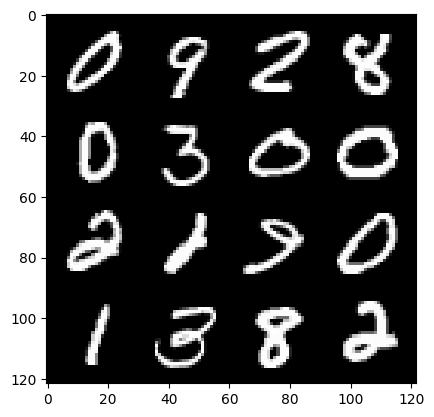

2: step: 1100 | Gen loss: 2.104202733039856 | Disc loss: 0.16425257772207258


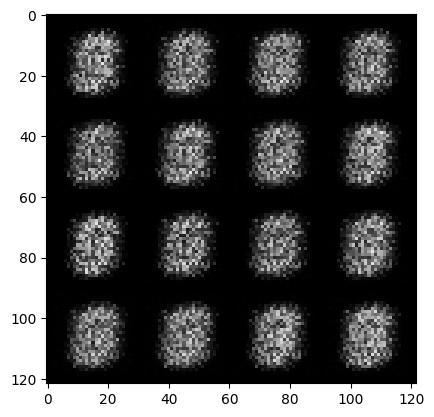

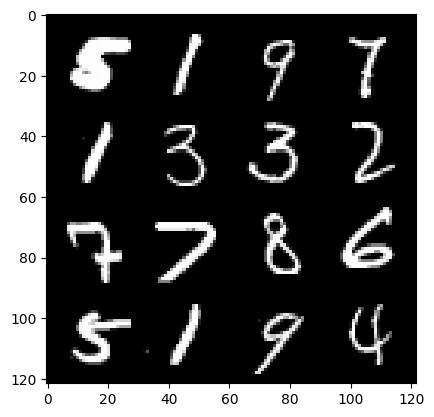

2: step: 1200 | Gen loss: 2.1464775252342223 | Disc loss: 0.1497308741509915


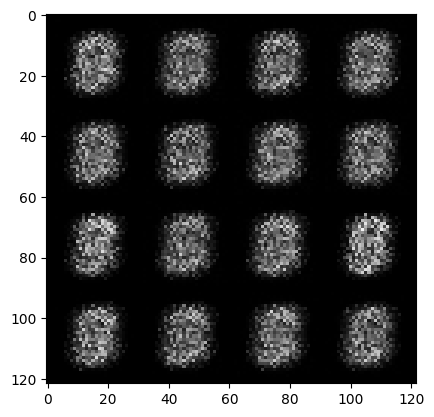

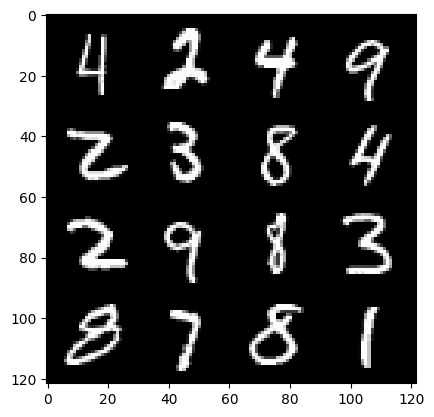

2: step: 1300 | Gen loss: 2.16020887851715 | Disc loss: 0.13898577772080892


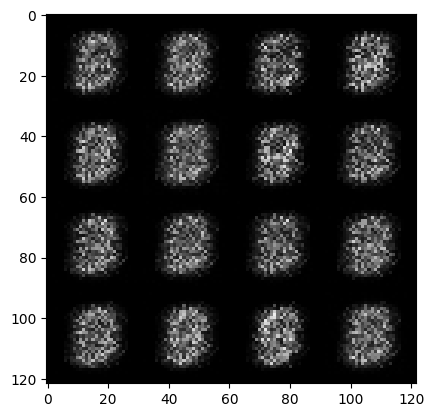

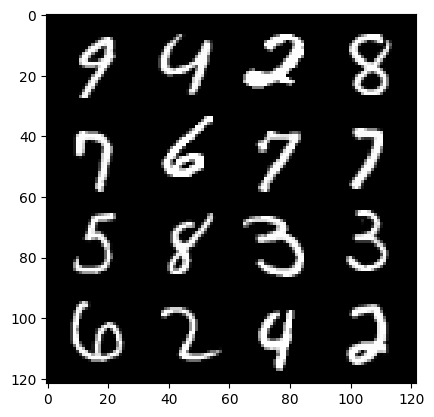

2: step: 1400 | Gen loss: 2.064261705875397 | Disc loss: 0.14975049376487734


  0%|          | 0/469 [00:00<?, ?it/s]

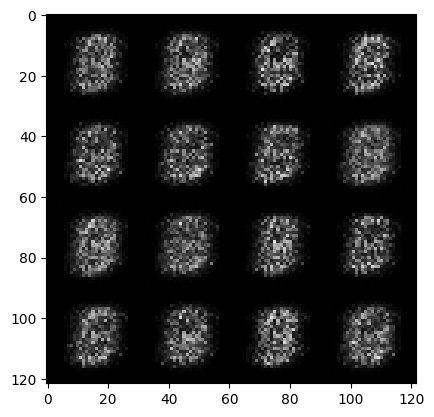

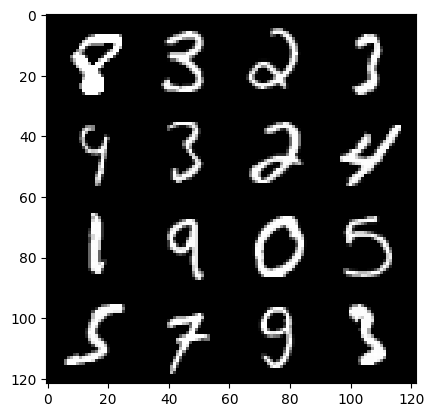

3: step: 1500 | Gen loss: 2.076165072917939 | Disc loss: 0.14383104458451268


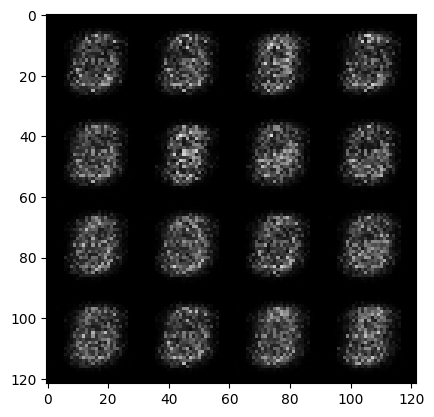

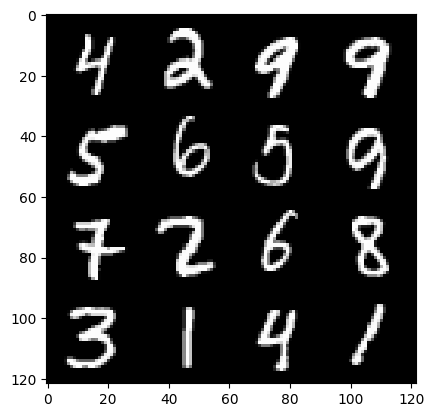

3: step: 1600 | Gen loss: 1.995792825222016 | Disc loss: 0.1562658314406872


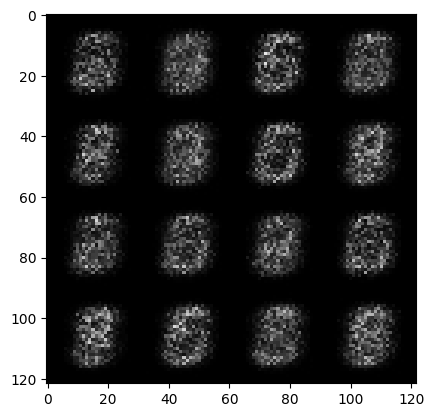

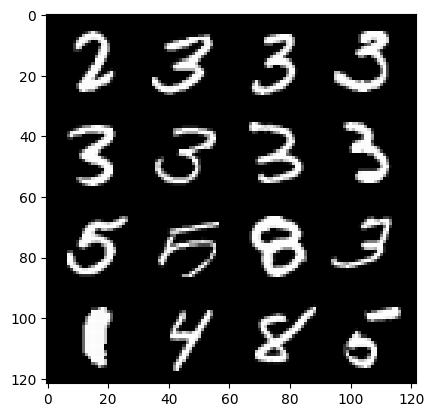

3: step: 1700 | Gen loss: 1.763749123811722 | Disc loss: 0.2067094011604786


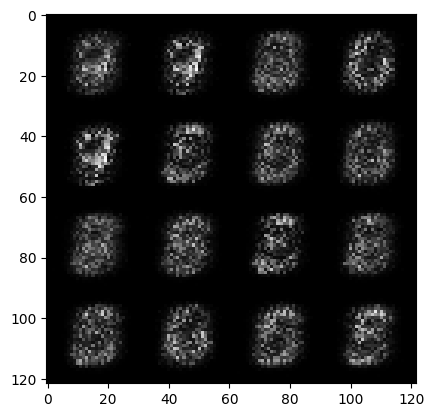

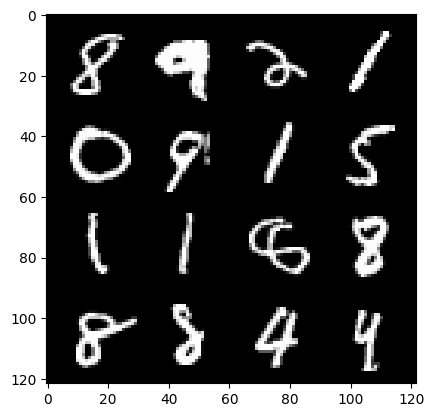

3: step: 1800 | Gen loss: 1.6874399578571317 | Disc loss: 0.2203120017051696


  0%|          | 0/469 [00:00<?, ?it/s]

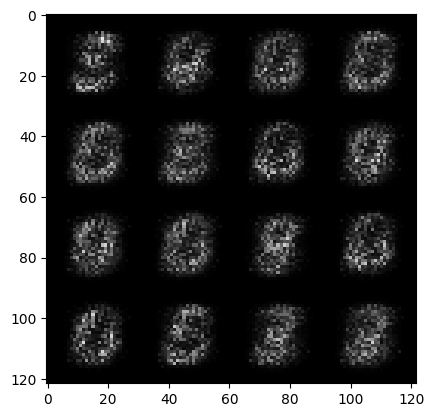

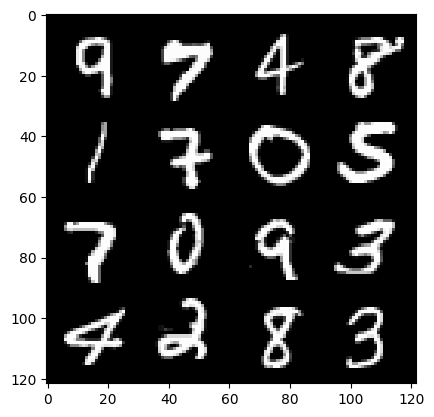

4: step: 1900 | Gen loss: 1.6461965072155003 | Disc loss: 0.23016742214560512


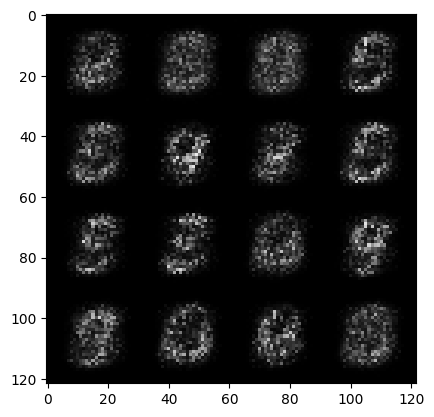

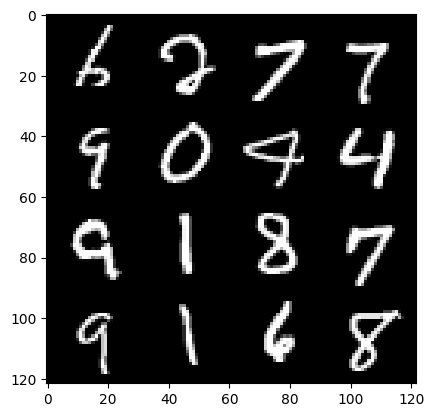

4: step: 2000 | Gen loss: 1.6067611062526703 | Disc loss: 0.2390489652752876


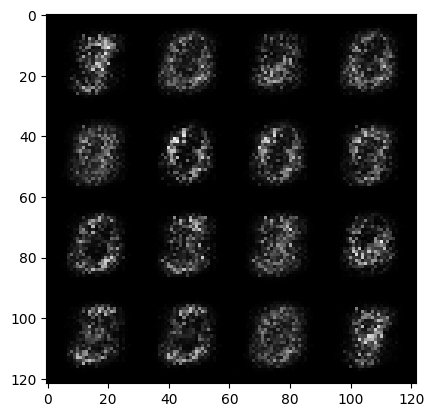

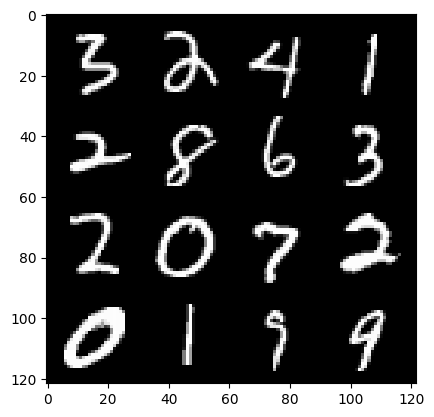

4: step: 2100 | Gen loss: 1.6380157601833345 | Disc loss: 0.21969887167215352


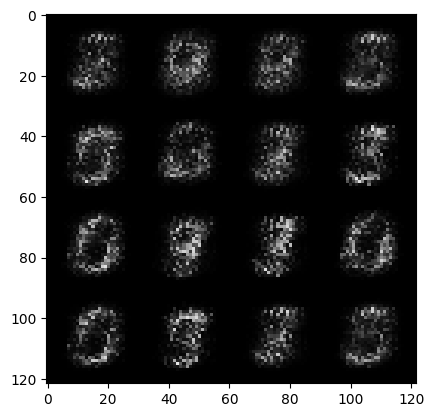

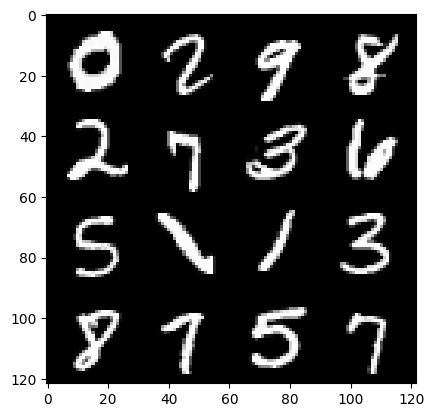

4: step: 2200 | Gen loss: 1.6287855970859524 | Disc loss: 0.2146860133111477


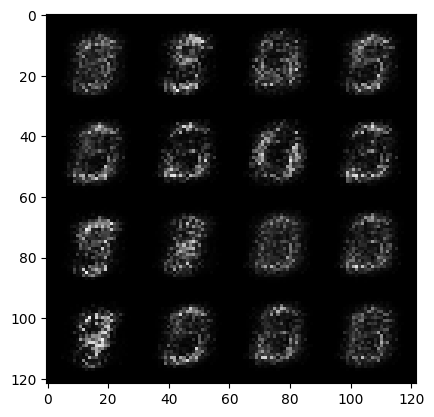

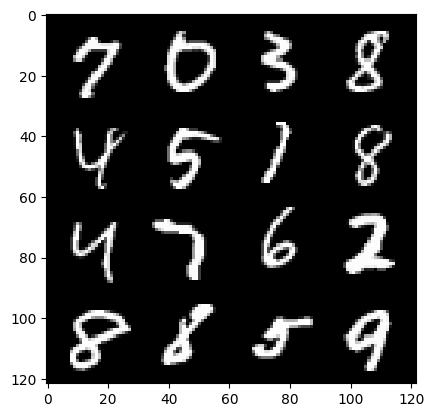

4: step: 2300 | Gen loss: 1.676934287548065 | Disc loss: 0.2027891336381435


  0%|          | 0/469 [00:00<?, ?it/s]

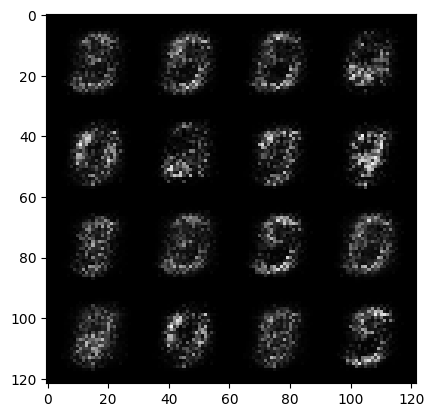

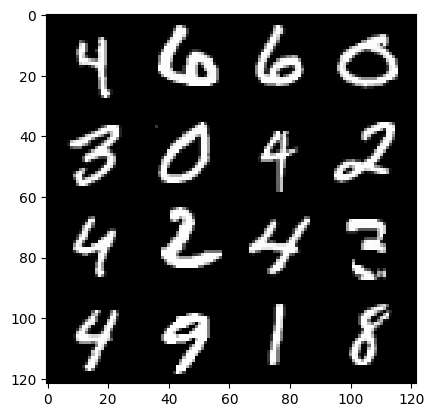

5: step: 2400 | Gen loss: 1.6949350583553315 | Disc loss: 0.20123645439743998


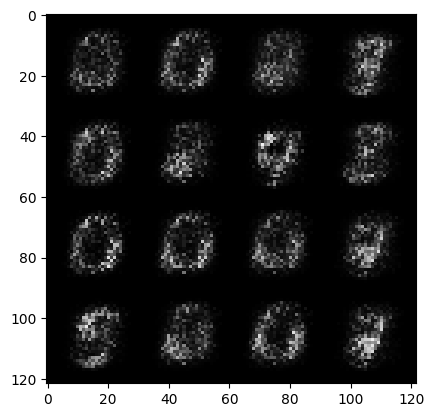

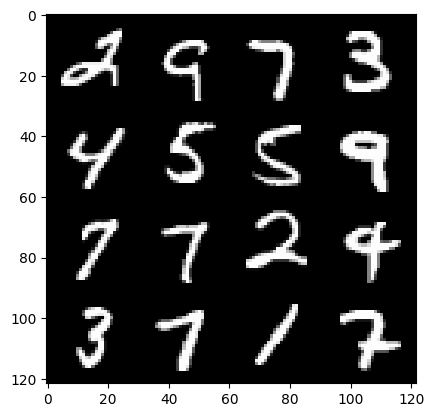

5: step: 2500 | Gen loss: 1.7052915358543397 | Disc loss: 0.20308131277561178


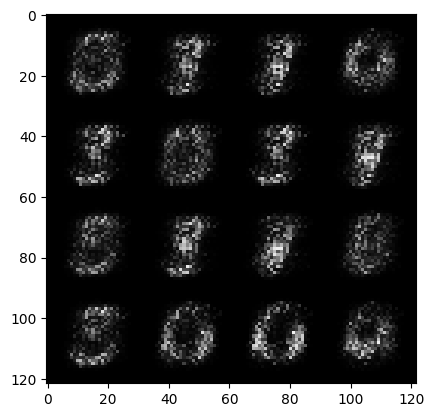

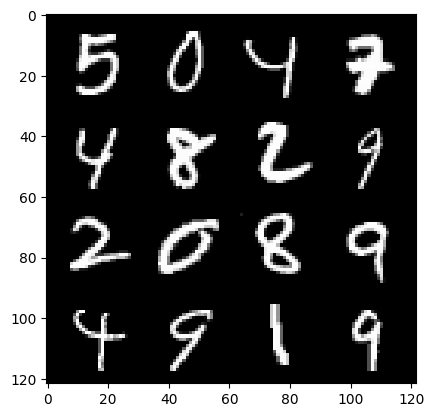

5: step: 2600 | Gen loss: 1.8503417611122133 | Disc loss: 0.17608636483550077


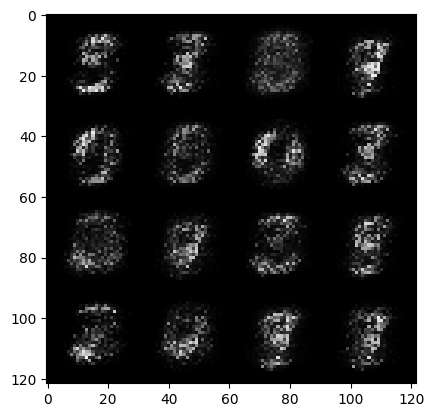

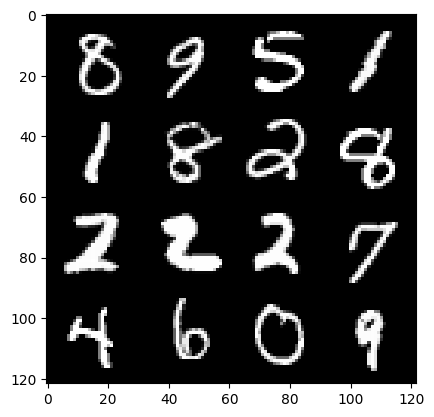

5: step: 2700 | Gen loss: 1.9300636160373694 | Disc loss: 0.16724840179085737


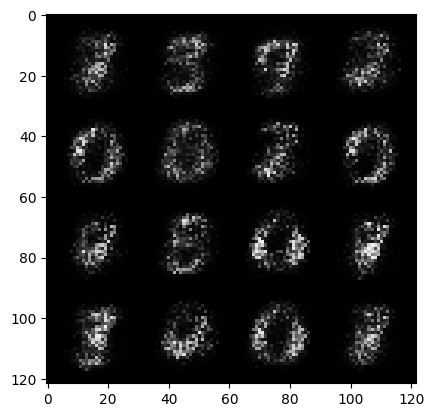

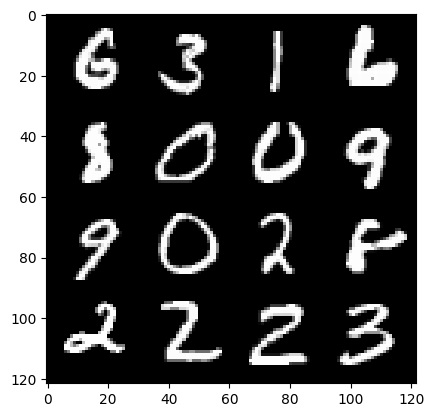

5: step: 2800 | Gen loss: 1.9423114633560177 | Disc loss: 0.16105438902974129


  0%|          | 0/469 [00:00<?, ?it/s]

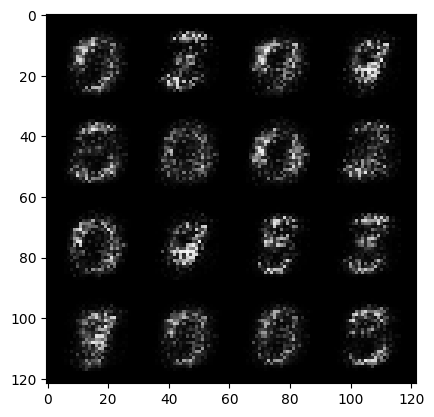

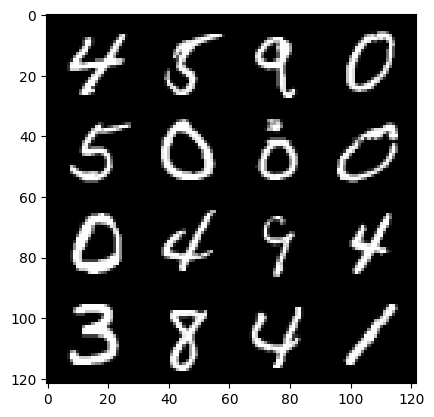

6: step: 2900 | Gen loss: 2.0376025462150578 | Disc loss: 0.1450495829433203


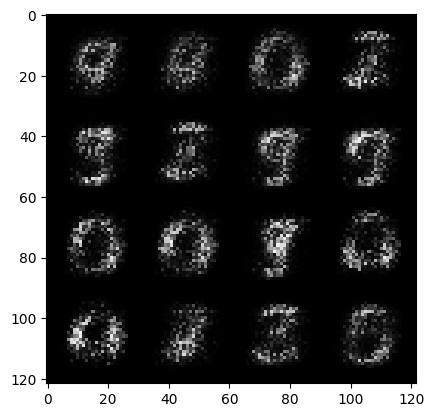

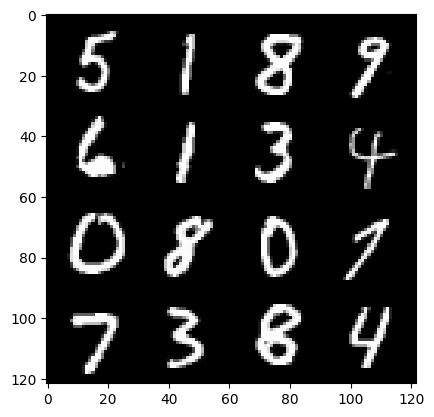

6: step: 3000 | Gen loss: 2.1270398330688476 | Disc loss: 0.1408608553558588


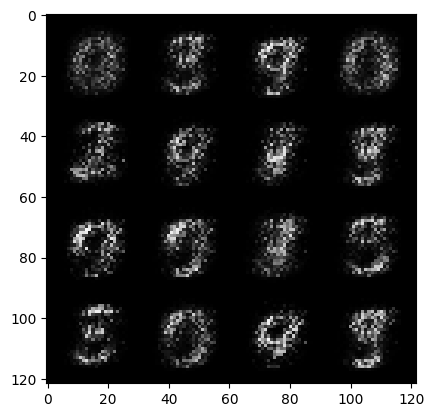

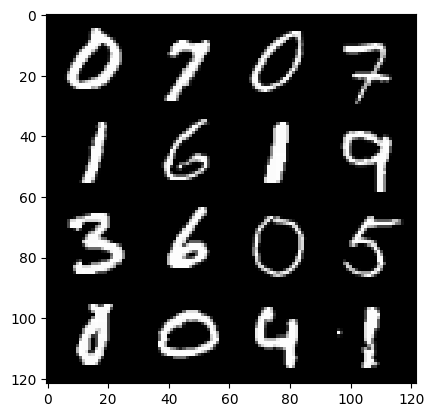

6: step: 3100 | Gen loss: 2.1829527854919437 | Disc loss: 0.13729860804975033


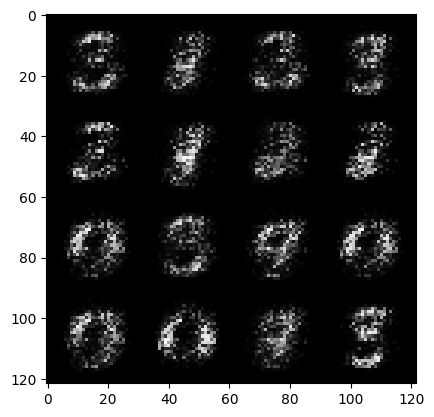

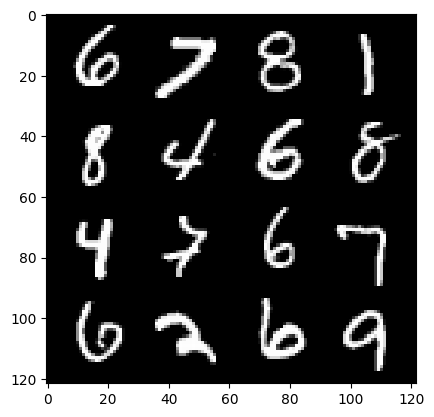

6: step: 3200 | Gen loss: 2.2839439702034 | Disc loss: 0.1277867446094751


  0%|          | 0/469 [00:00<?, ?it/s]

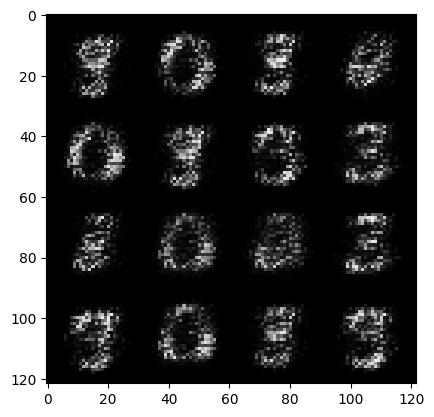

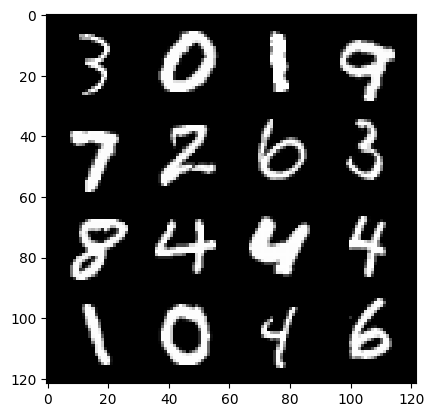

7: step: 3300 | Gen loss: 2.4149492764472957 | Disc loss: 0.11600587449967861


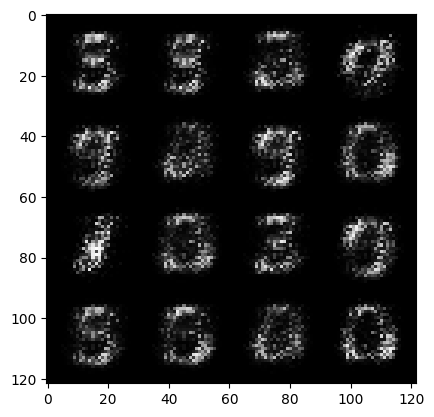

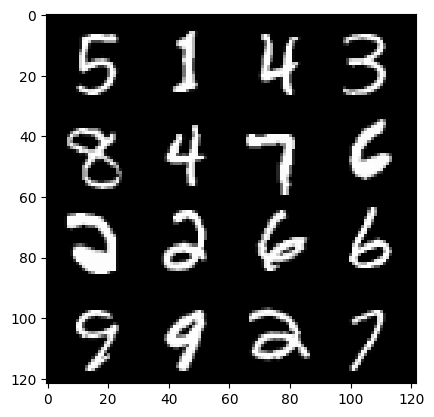

7: step: 3400 | Gen loss: 2.5738904118537915 | Disc loss: 0.10271501883864402


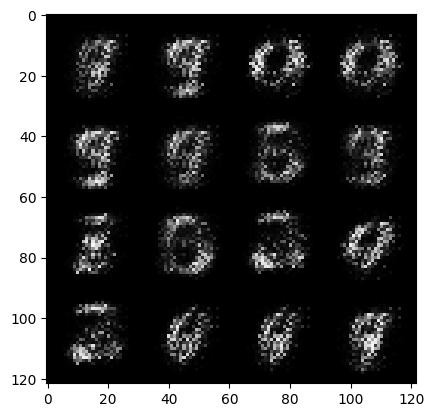

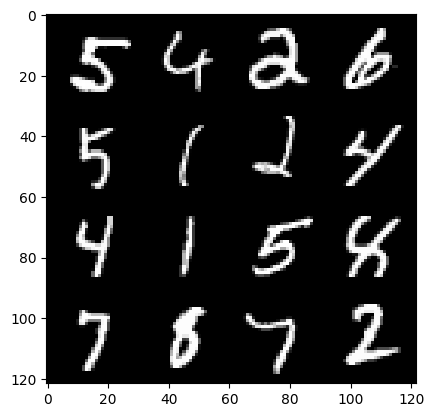

7: step: 3500 | Gen loss: 2.6133468103408815 | Disc loss: 0.10307764835655689


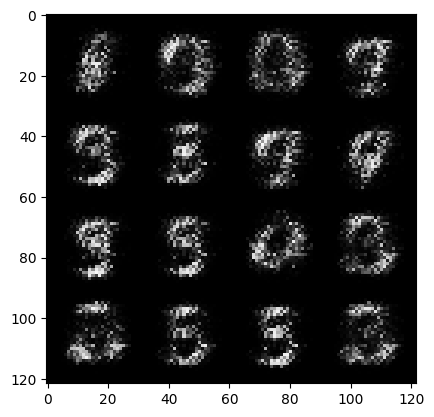

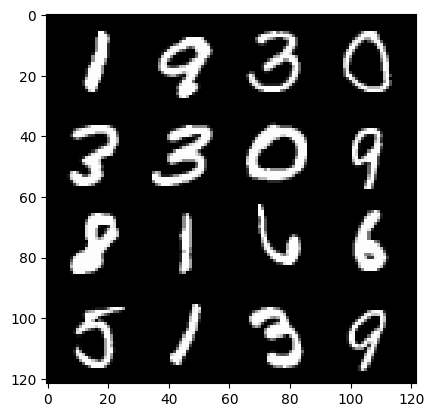

7: step: 3600 | Gen loss: 2.5841696834564223 | Disc loss: 0.11009637877345088


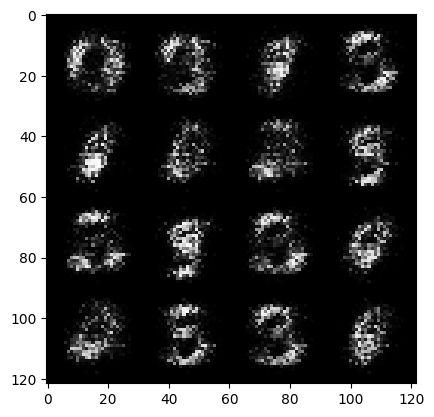

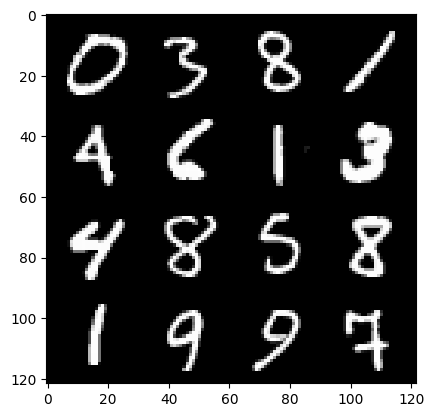

7: step: 3700 | Gen loss: 2.6025247001647944 | Disc loss: 0.11619407393038271


  0%|          | 0/469 [00:00<?, ?it/s]

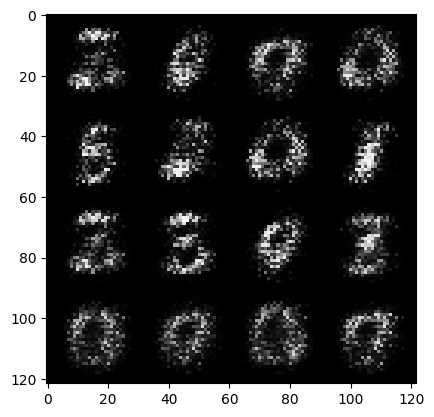

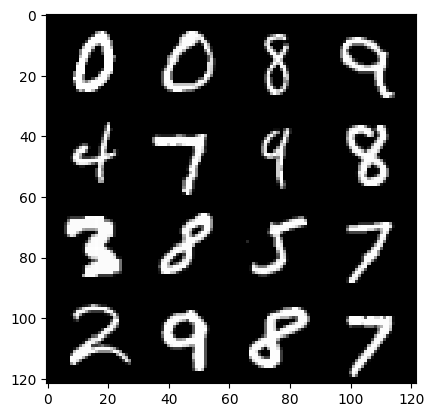

8: step: 3800 | Gen loss: 2.753470947742463 | Disc loss: 0.1057290504872799


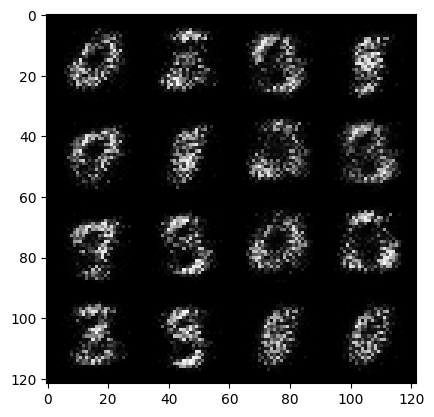

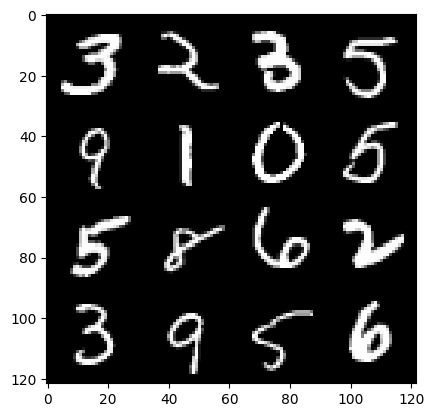

8: step: 3900 | Gen loss: 2.8254133939743054 | Disc loss: 0.09863025389611721


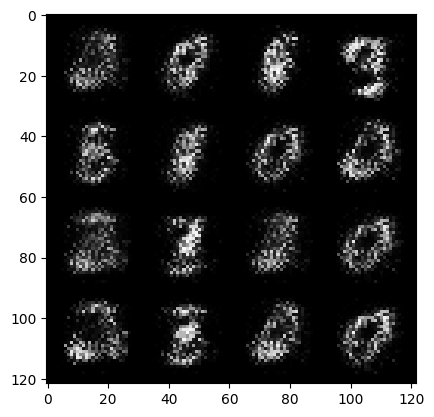

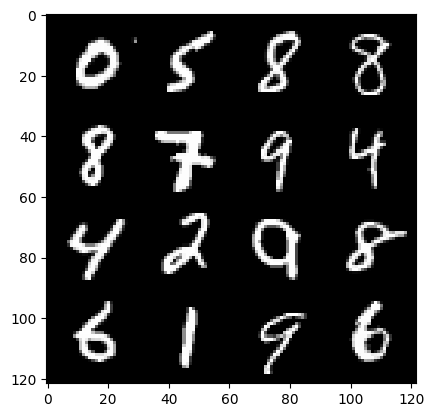

8: step: 4000 | Gen loss: 2.8187693309783923 | Disc loss: 0.10447510249912739


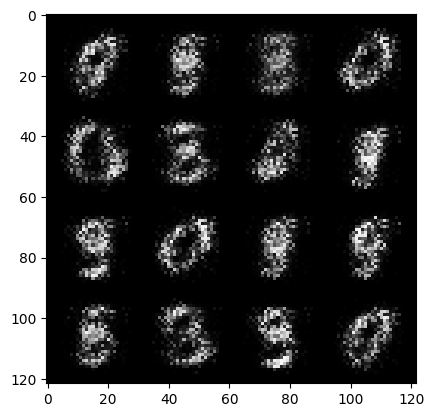

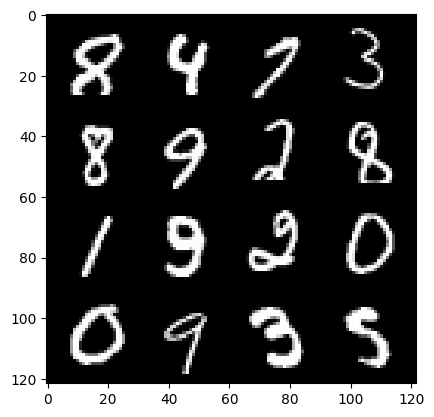

8: step: 4100 | Gen loss: 2.9693115592002886 | Disc loss: 0.10098551928997043


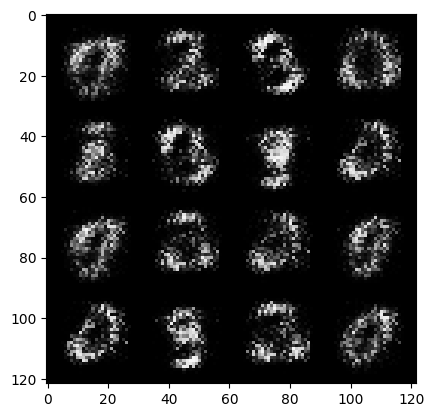

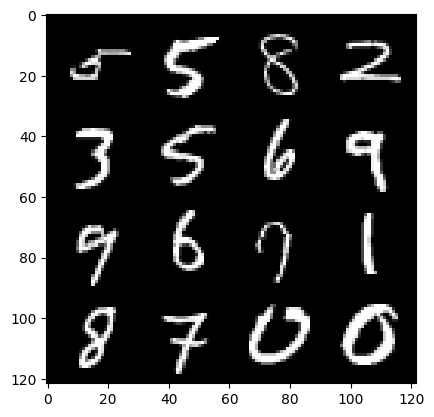

8: step: 4200 | Gen loss: 3.0051281785964976 | Disc loss: 0.104559523165226


  0%|          | 0/469 [00:00<?, ?it/s]

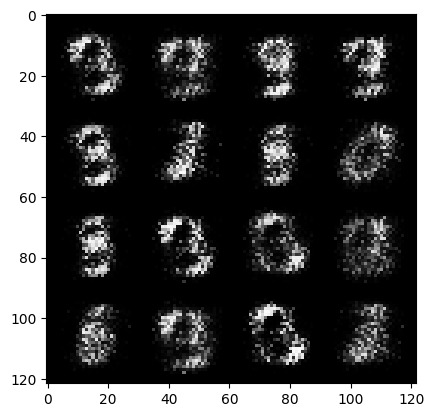

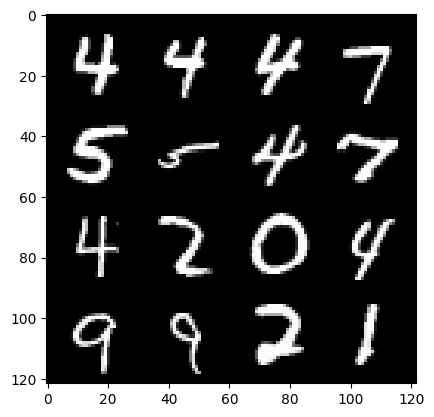

9: step: 4300 | Gen loss: 3.0578853726387027 | Disc loss: 0.09743370890617377


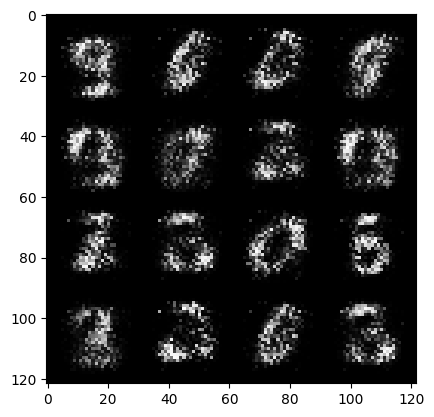

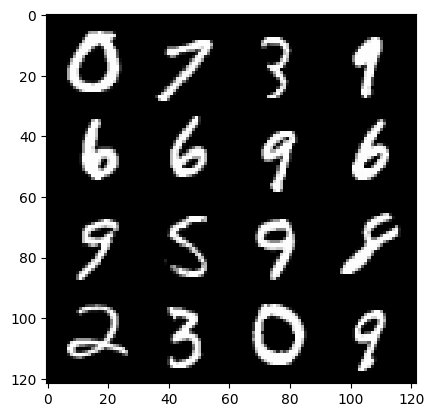

9: step: 4400 | Gen loss: 3.1540561103820797 | Disc loss: 0.08872565656900405


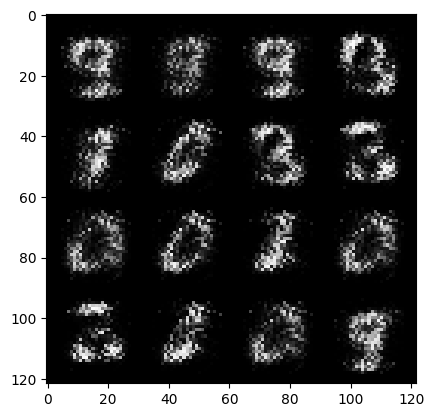

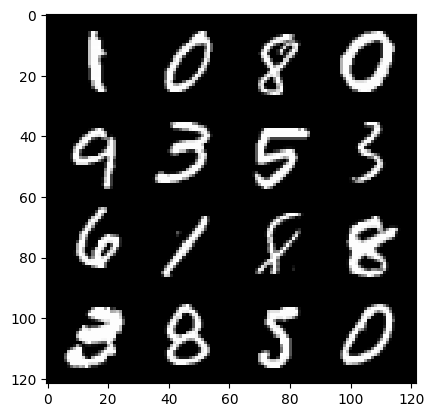

9: step: 4500 | Gen loss: 3.4025492119789122 | Disc loss: 0.08224681098014115


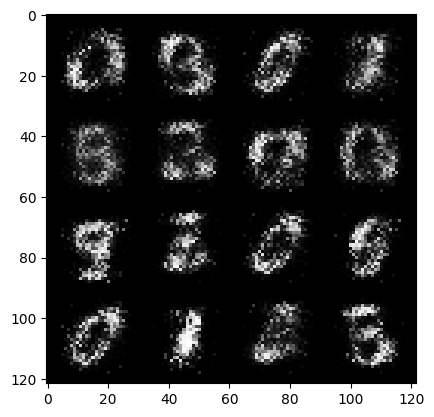

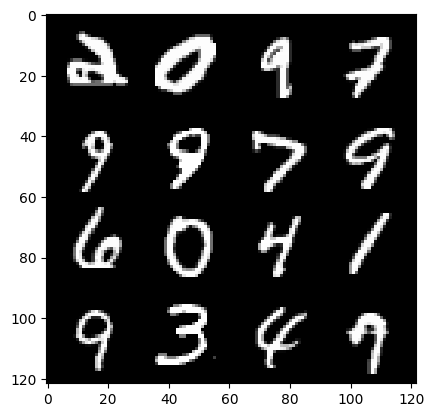

9: step: 4600 | Gen loss: 3.3369525170326235 | Disc loss: 0.09179099828004837


  0%|          | 0/469 [00:00<?, ?it/s]

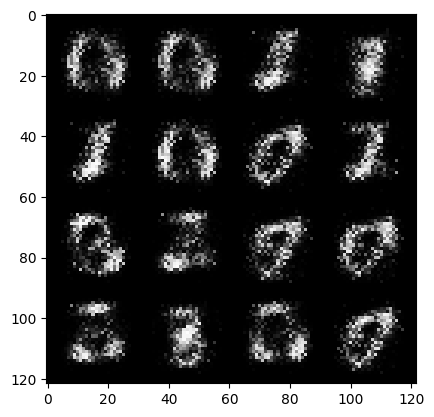

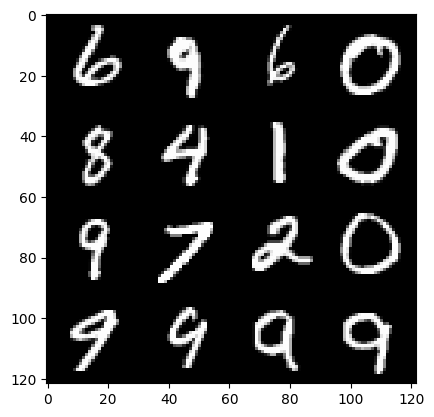

10: step: 4700 | Gen loss: 3.313709585666656 | Disc loss: 0.09145731907337899


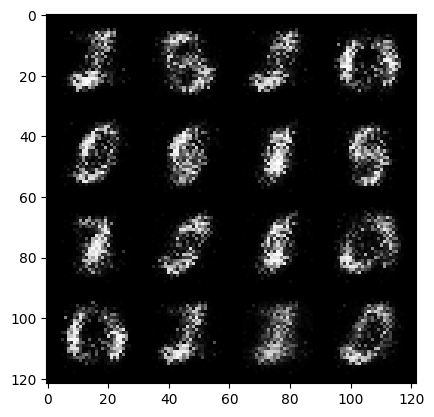

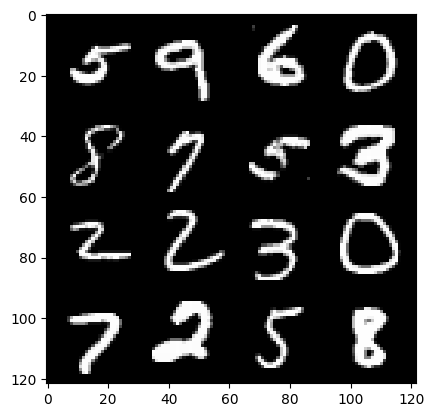

10: step: 4800 | Gen loss: 3.336905190944672 | Disc loss: 0.09264881726354358


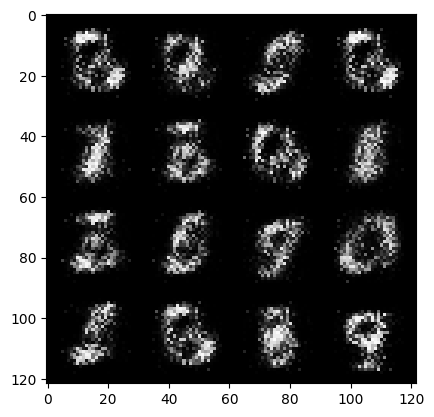

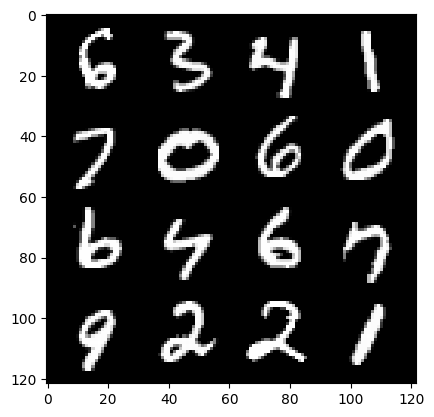

10: step: 4900 | Gen loss: 3.4454338812828063 | Disc loss: 0.08143558856099842


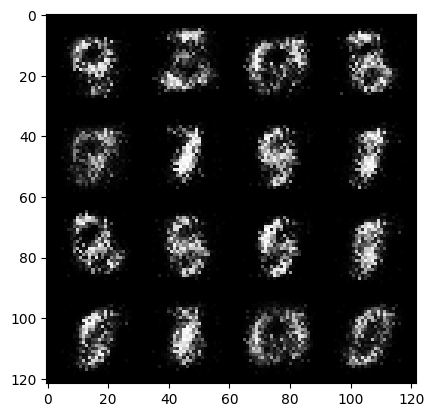

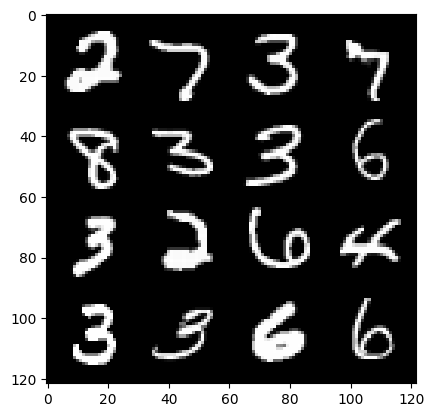

10: step: 5000 | Gen loss: 3.547771966457368 | Disc loss: 0.07274782095104453


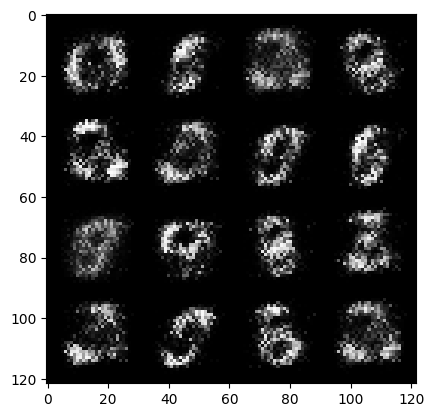

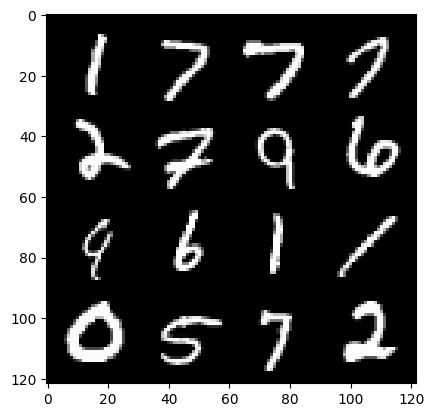

10: step: 5100 | Gen loss: 3.513759791851044 | Disc loss: 0.07689884856343271


  0%|          | 0/469 [00:00<?, ?it/s]

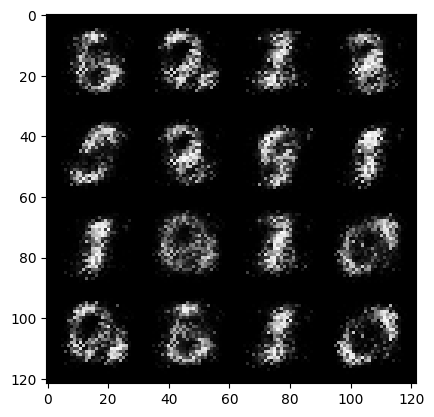

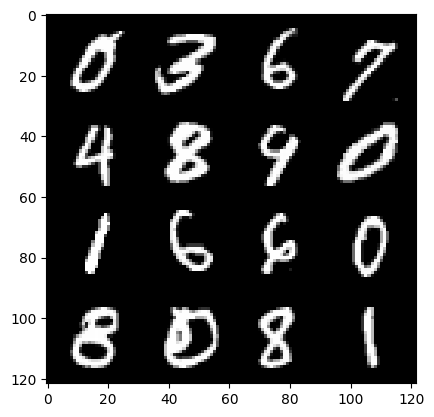

11: step: 5200 | Gen loss: 3.434988322257994 | Disc loss: 0.08402439970523119


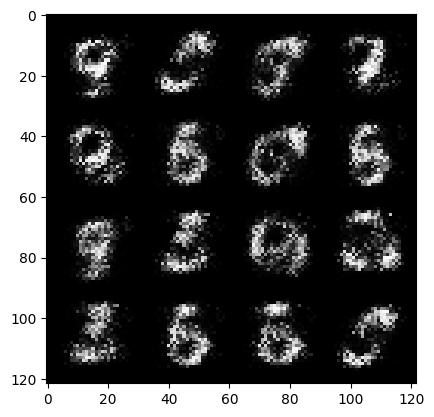

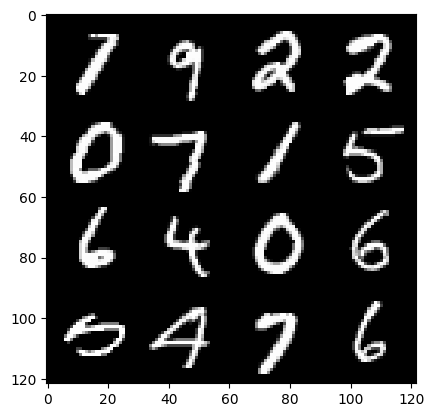

11: step: 5300 | Gen loss: 3.308290383815767 | Disc loss: 0.09077974893152711


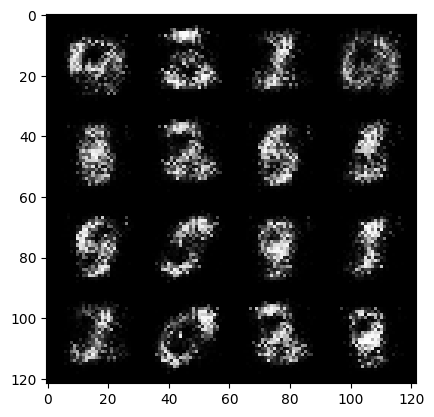

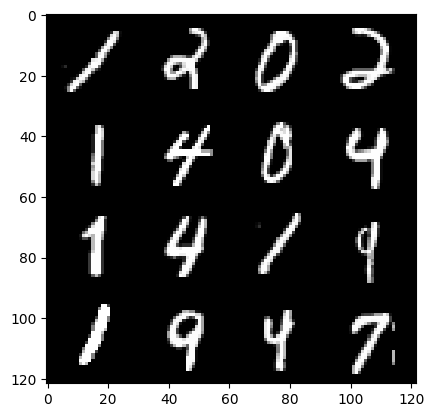

11: step: 5400 | Gen loss: 3.4490133476257303 | Disc loss: 0.08038190912455322


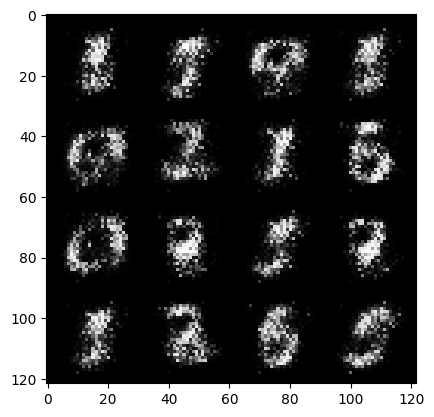

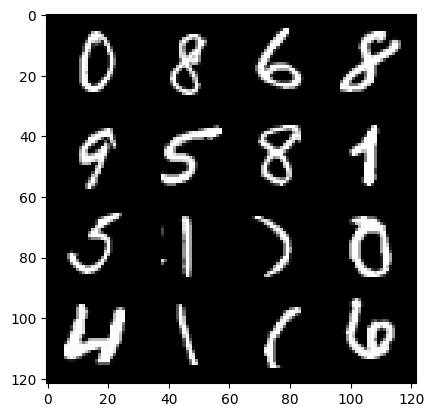

11: step: 5500 | Gen loss: 3.6618799495697023 | Disc loss: 0.06691797684878109


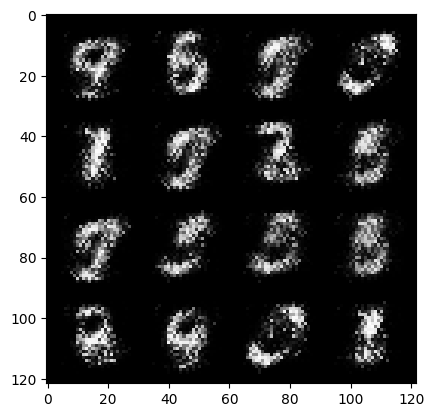

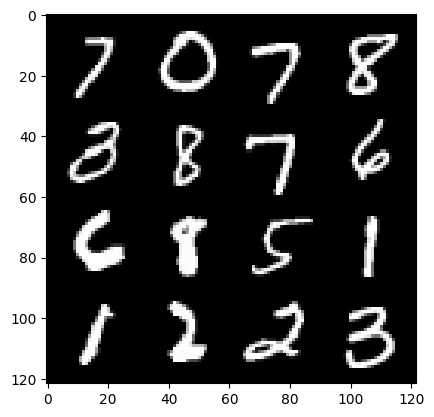

11: step: 5600 | Gen loss: 3.7823336148262032 | Disc loss: 0.061933946758508676


  0%|          | 0/469 [00:00<?, ?it/s]

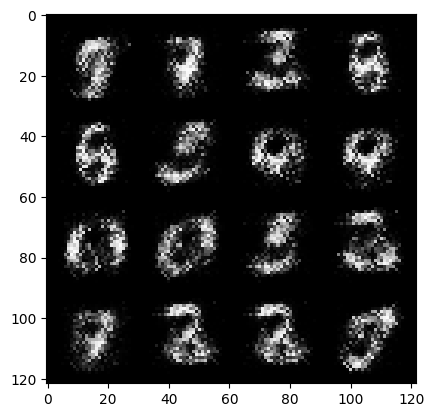

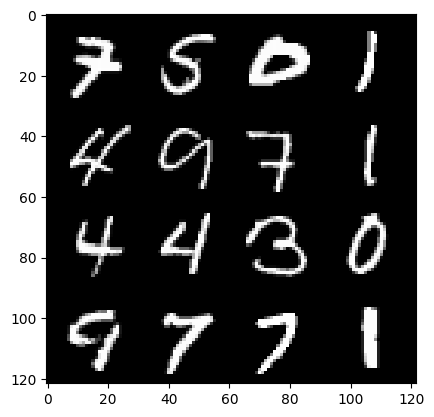

12: step: 5700 | Gen loss: 3.880965983867644 | Disc loss: 0.06218110494315624


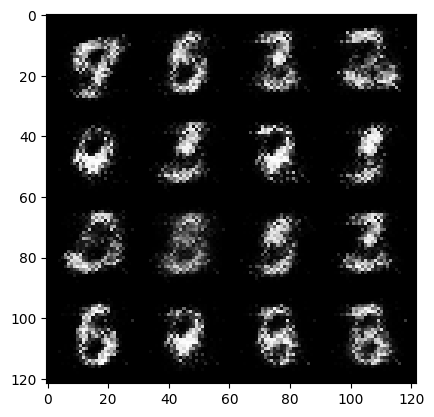

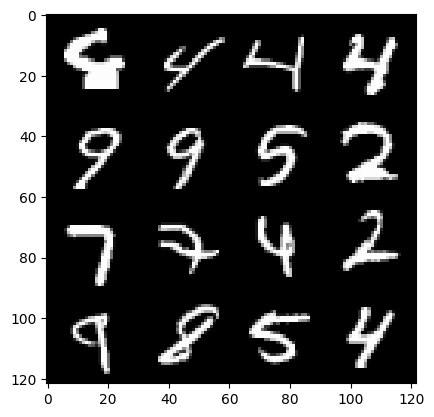

12: step: 5800 | Gen loss: 3.8927453732490536 | Disc loss: 0.05963968925178054


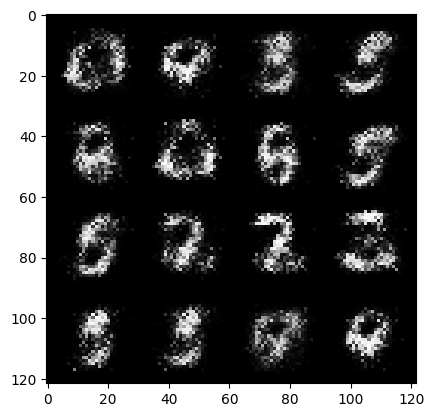

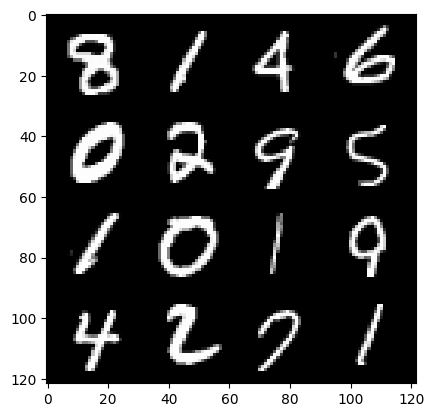

12: step: 5900 | Gen loss: 3.9851914167404163 | Disc loss: 0.05814037561416629


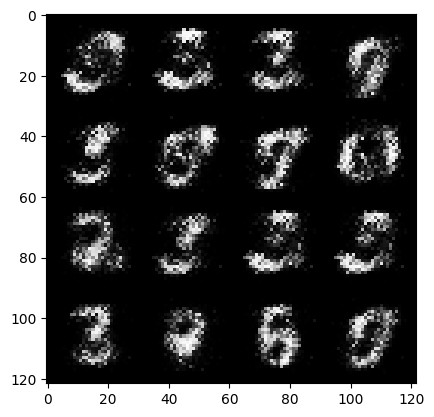

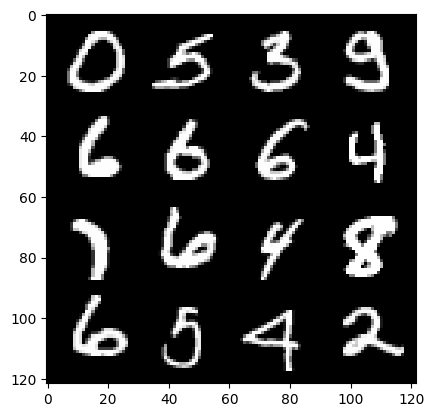

12: step: 6000 | Gen loss: 4.015219652652739 | Disc loss: 0.05509791702032088


  0%|          | 0/469 [00:00<?, ?it/s]

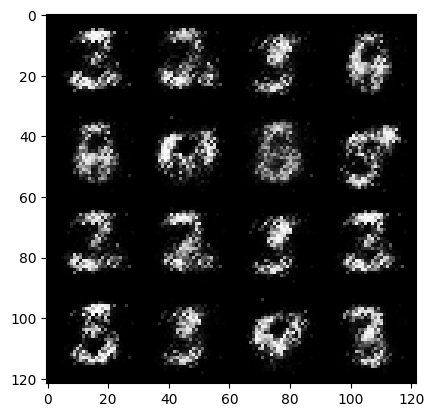

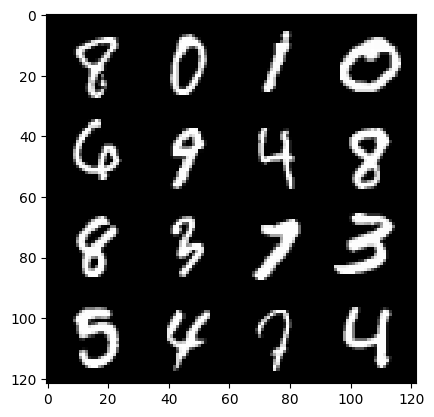

13: step: 6100 | Gen loss: 4.150072393417359 | Disc loss: 0.050154465511441204


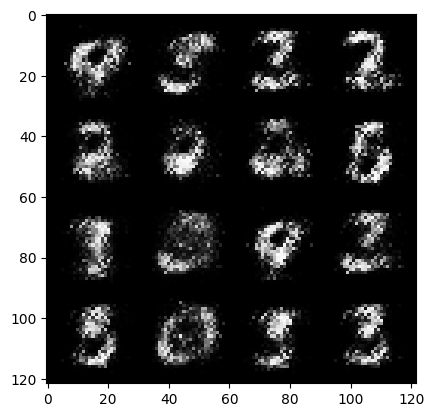

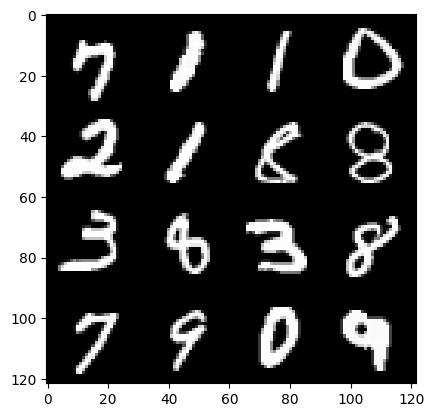

13: step: 6200 | Gen loss: 4.151462457180021 | Disc loss: 0.050423177964985376


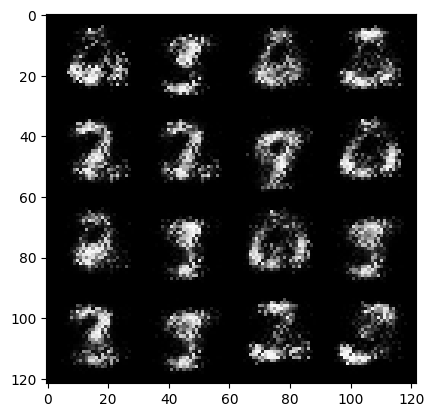

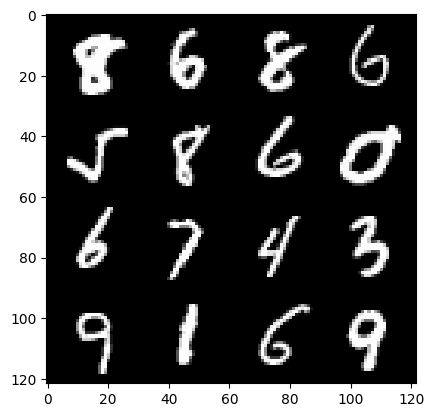

13: step: 6300 | Gen loss: 4.170997912883757 | Disc loss: 0.052166779674589644


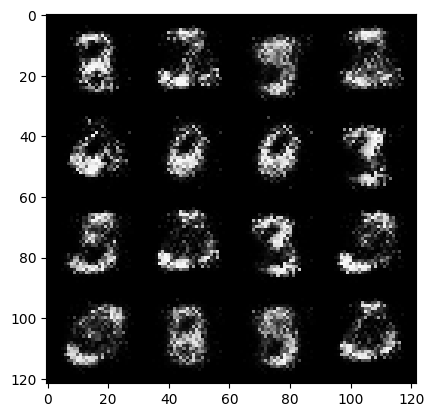

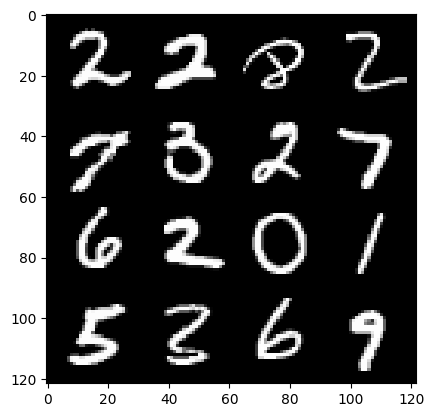

13: step: 6400 | Gen loss: 4.234489912986756 | Disc loss: 0.04911972377449272


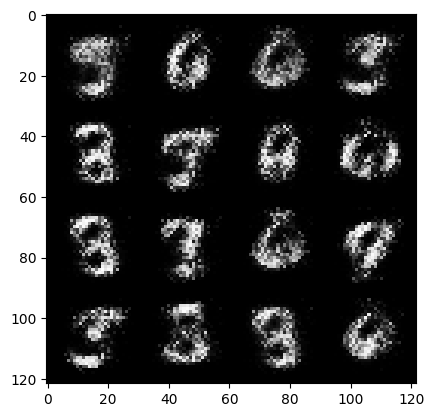

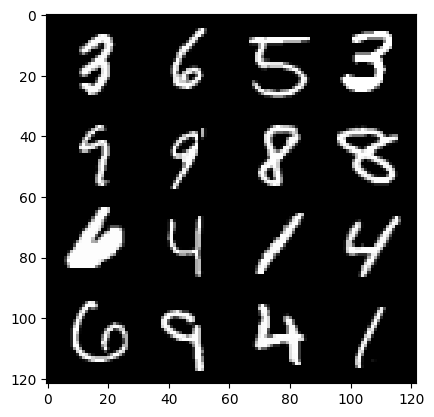

13: step: 6500 | Gen loss: 4.341427118778232 | Disc loss: 0.0453903025202453


  0%|          | 0/469 [00:00<?, ?it/s]

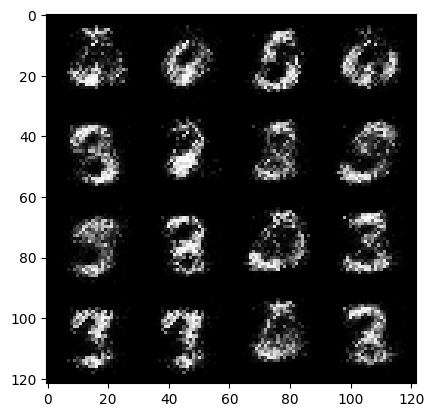

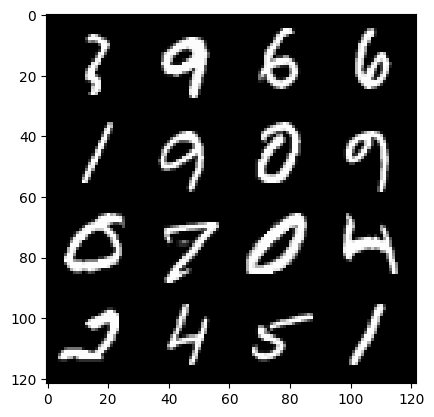

14: step: 6600 | Gen loss: 4.316079704761504 | Disc loss: 0.04542036321014164


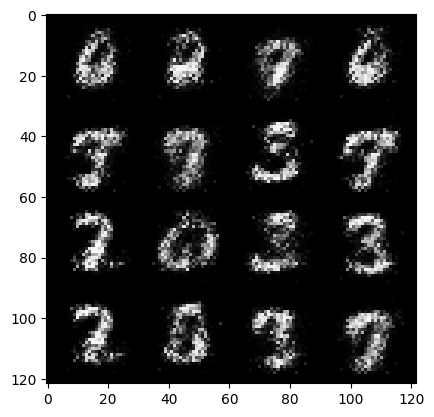

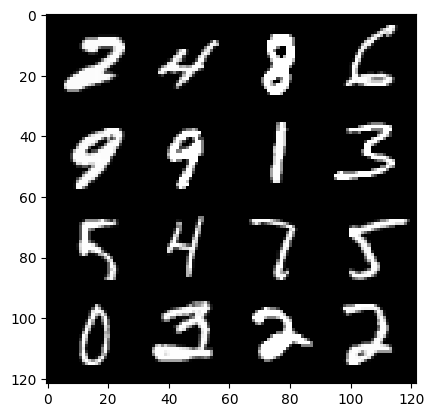

14: step: 6700 | Gen loss: 4.261172301769257 | Disc loss: 0.0488322659395635


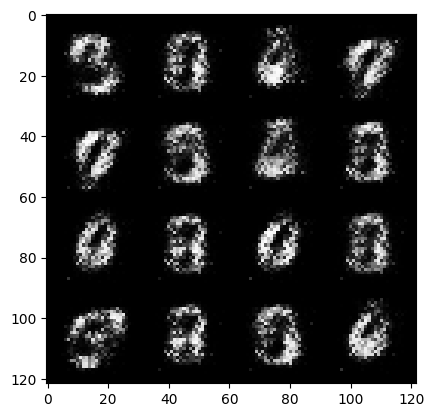

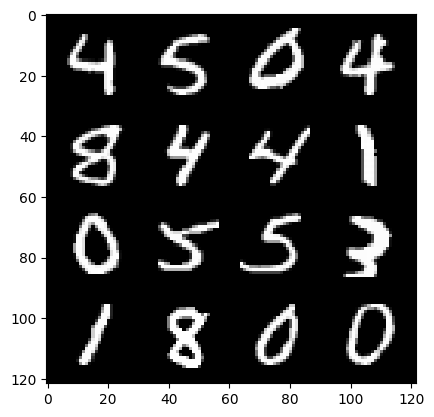

14: step: 6800 | Gen loss: 4.250595390796661 | Disc loss: 0.053421908561140305


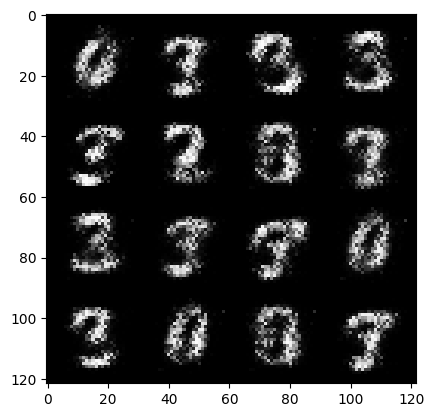

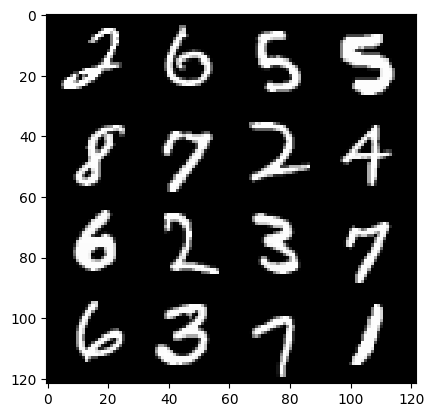

14: step: 6900 | Gen loss: 4.2923577833175655 | Disc loss: 0.05410671679303052


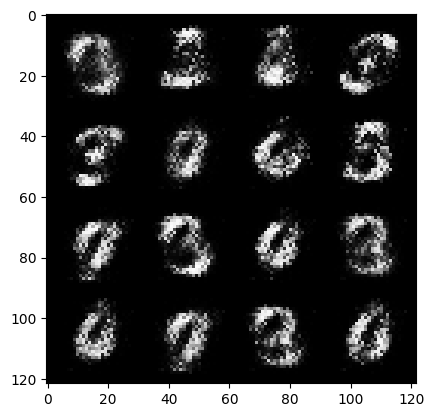

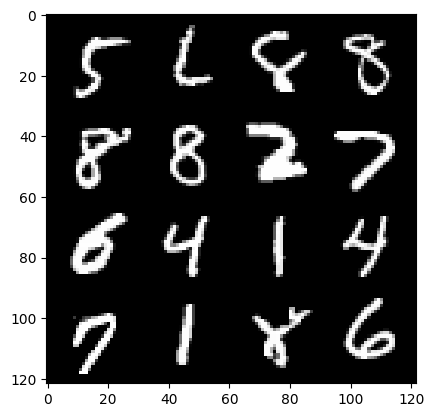

14: step: 7000 | Gen loss: 4.210897235870362 | Disc loss: 0.05412787582725287


  0%|          | 0/469 [00:00<?, ?it/s]

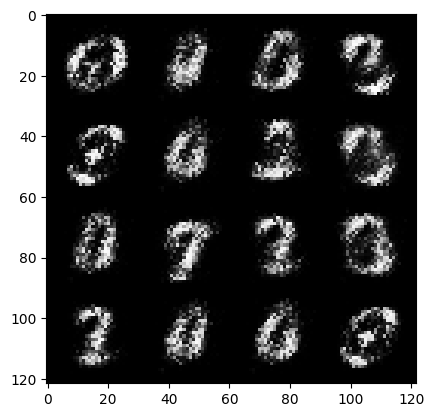

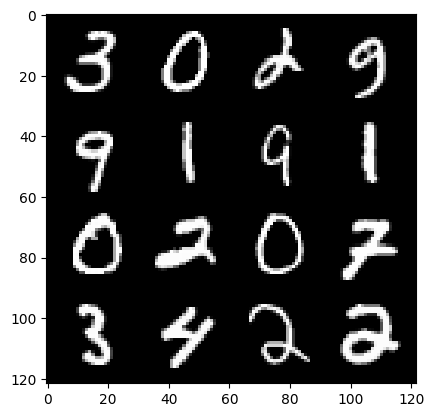

15: step: 7100 | Gen loss: 4.1559346628189076 | Disc loss: 0.05966089259833094


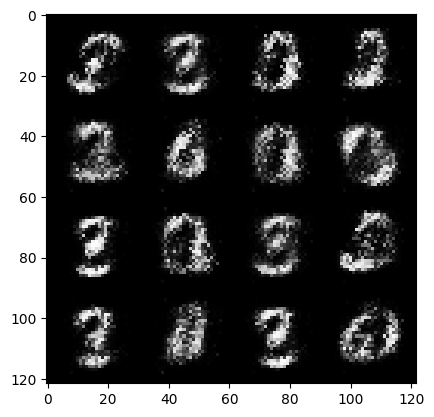

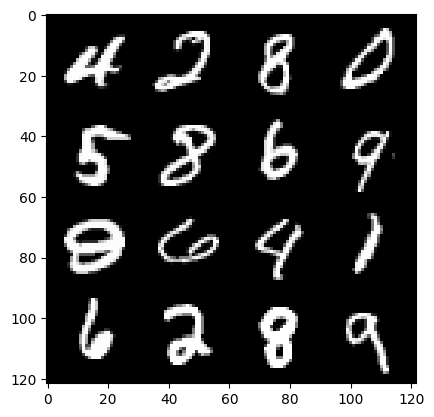

15: step: 7200 | Gen loss: 4.148918504714966 | Disc loss: 0.060946060232818136


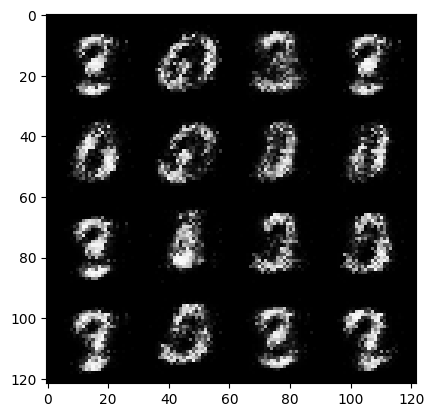

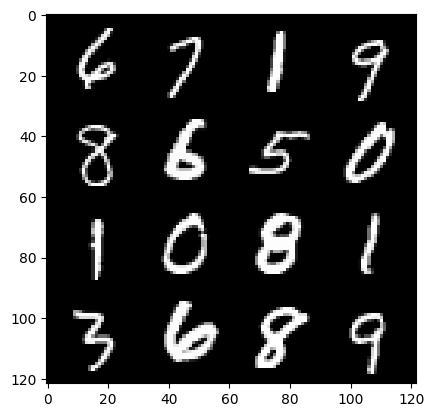

15: step: 7300 | Gen loss: 4.082567579746246 | Disc loss: 0.0650693817436695


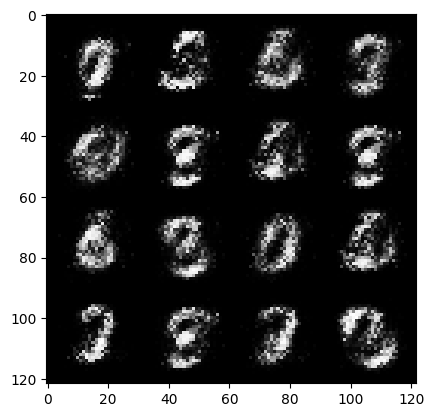

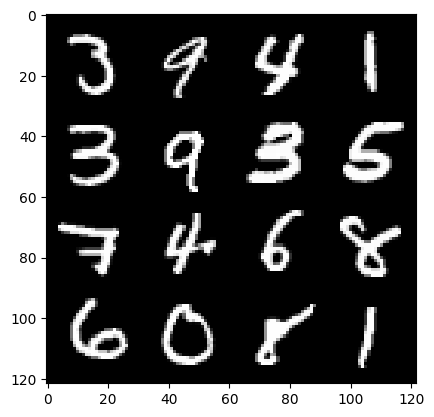

15: step: 7400 | Gen loss: 3.98687338590622 | Disc loss: 0.06830627094954252


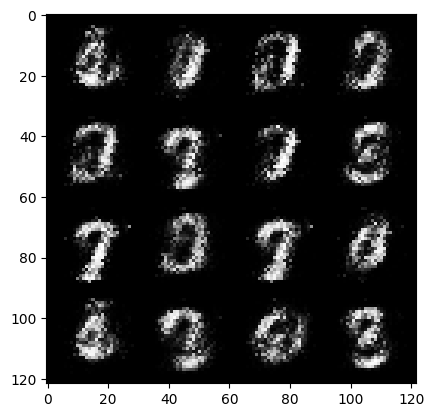

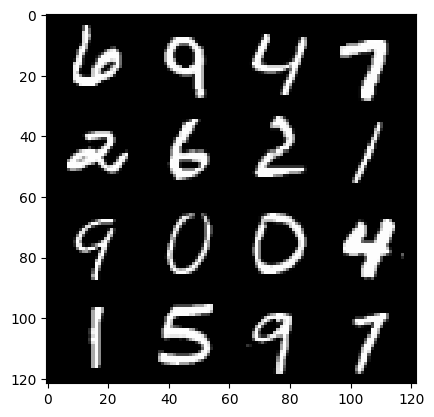

15: step: 7500 | Gen loss: 4.008231954574586 | Disc loss: 0.0744463240727782


  0%|          | 0/469 [00:00<?, ?it/s]

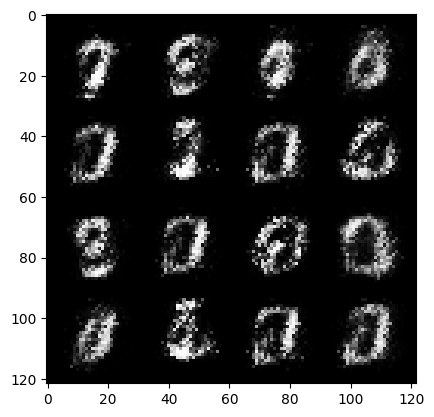

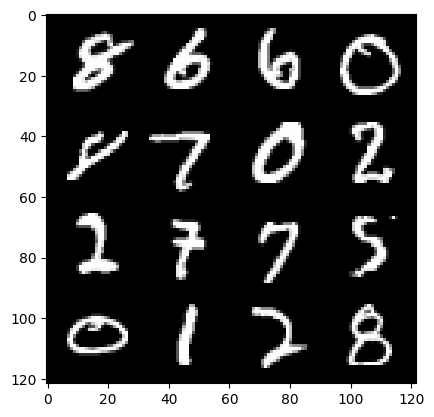

16: step: 7600 | Gen loss: 4.09590161561966 | Disc loss: 0.07684528417885308


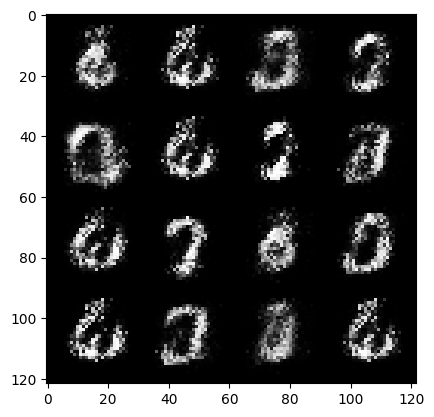

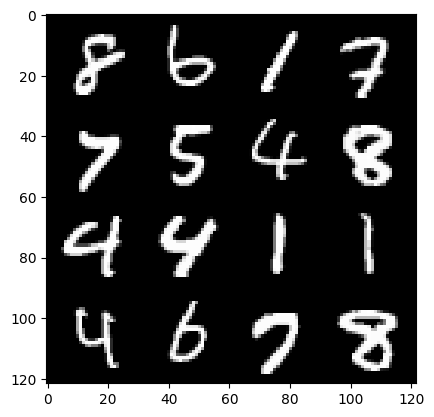

16: step: 7700 | Gen loss: 4.285685534477234 | Disc loss: 0.06690327640622852


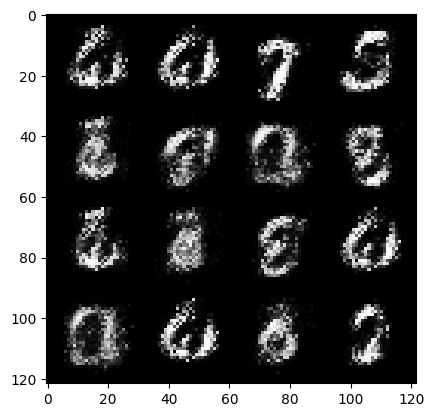

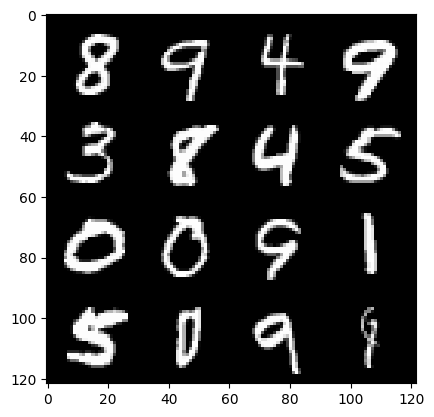

16: step: 7800 | Gen loss: 4.358923795223235 | Disc loss: 0.05955022038891911


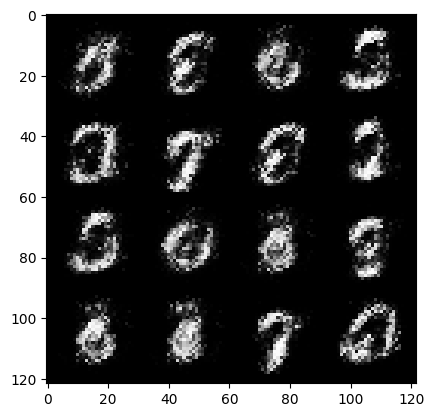

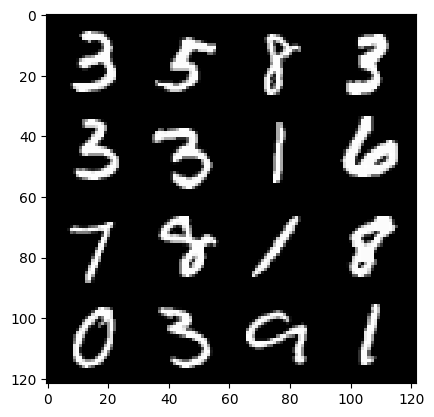

16: step: 7900 | Gen loss: 4.1911901450157165 | Disc loss: 0.05949435908347369


  0%|          | 0/469 [00:00<?, ?it/s]

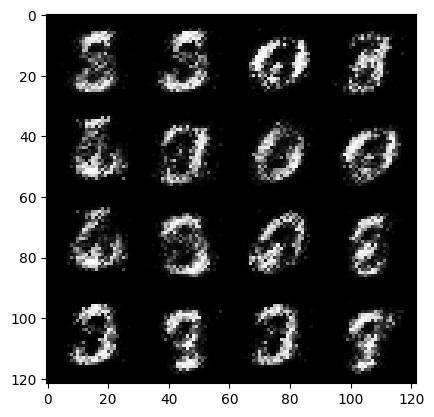

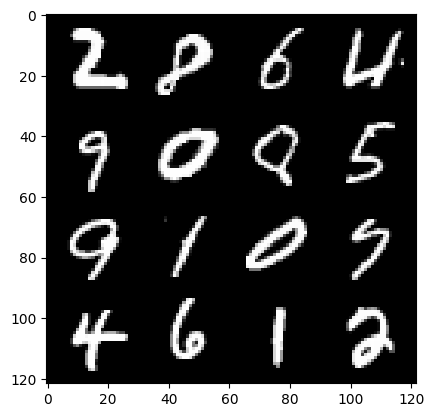

17: step: 8000 | Gen loss: 4.06731339931488 | Disc loss: 0.06002107605338097


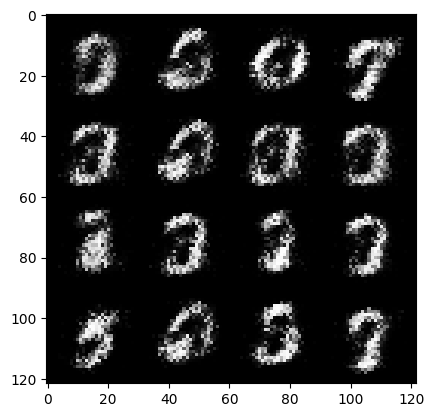

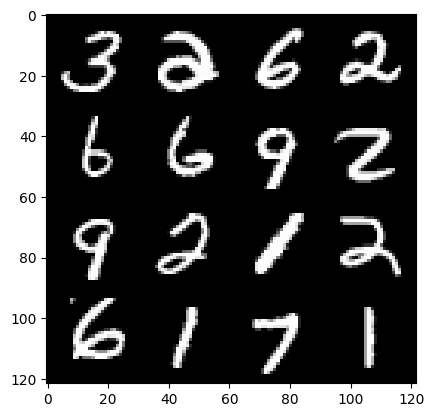

17: step: 8100 | Gen loss: 4.062437179088593 | Disc loss: 0.05822725031524897


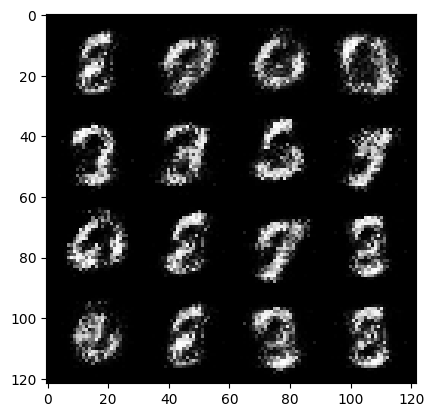

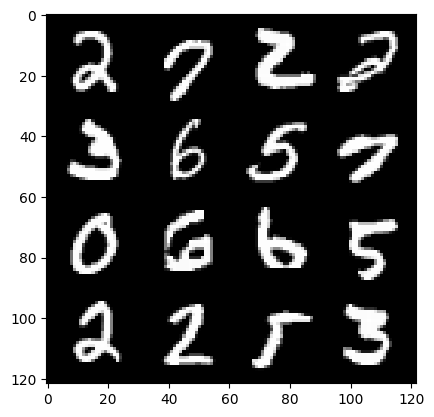

17: step: 8200 | Gen loss: 4.268768763542173 | Disc loss: 0.051350852437317365


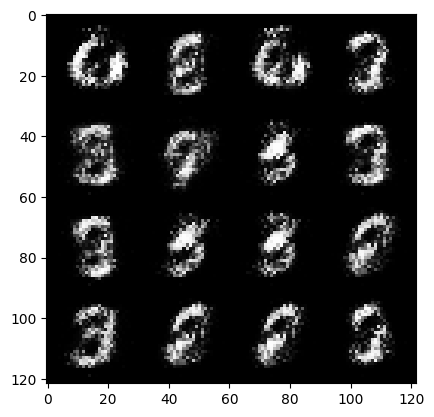

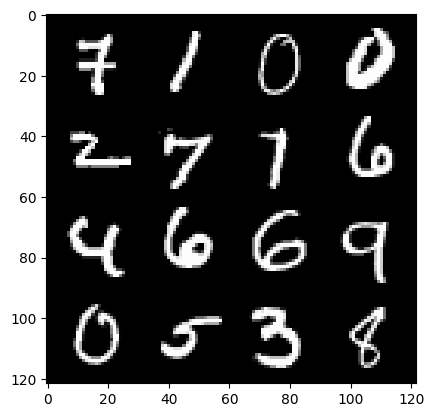

17: step: 8300 | Gen loss: 4.376341383457183 | Disc loss: 0.05401259735226631


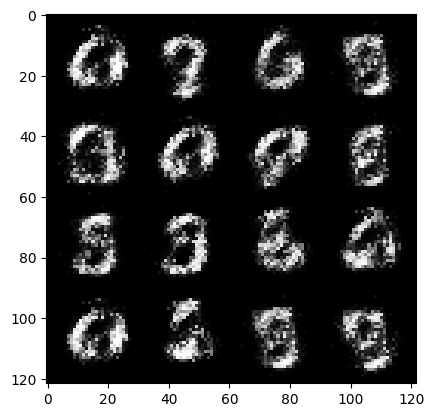

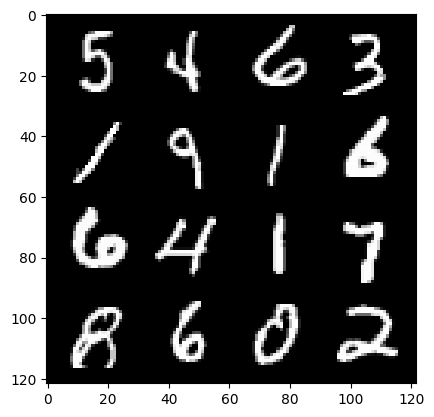

17: step: 8400 | Gen loss: 4.376458671092986 | Disc loss: 0.05368891606107355


  0%|          | 0/469 [00:00<?, ?it/s]

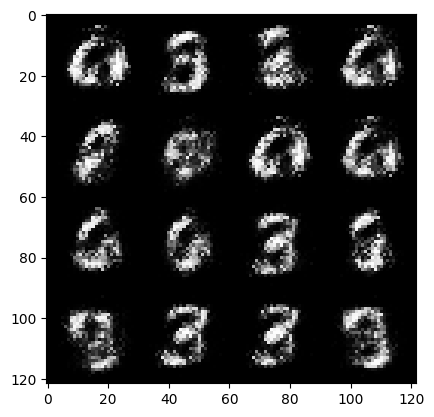

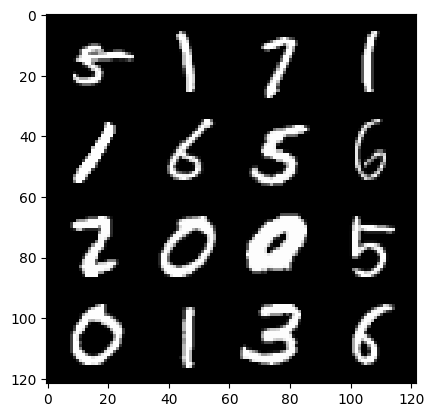

18: step: 8500 | Gen loss: 4.173213756084443 | Disc loss: 0.058648746982216816


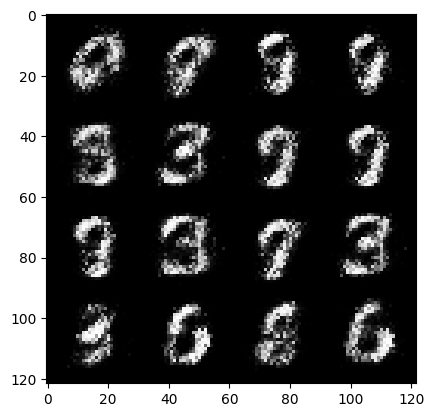

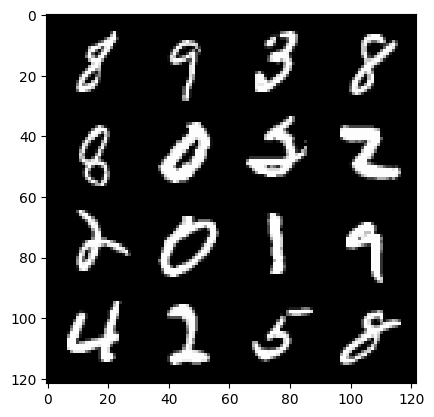

18: step: 8600 | Gen loss: 3.980611855983734 | Disc loss: 0.062443155758082874


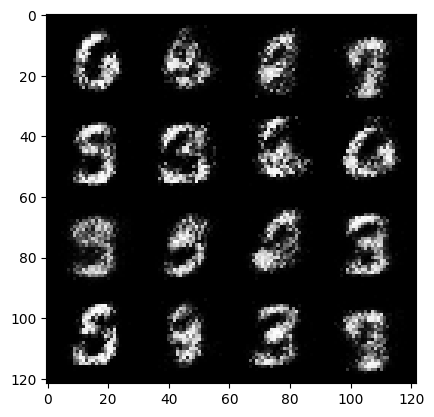

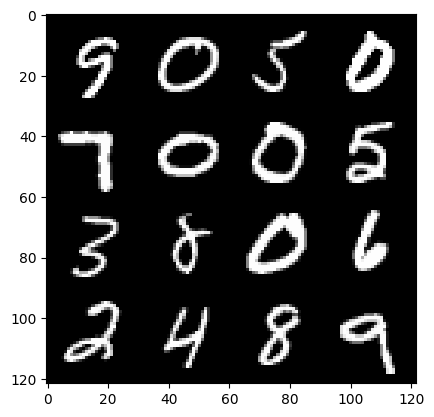

18: step: 8700 | Gen loss: 3.988869941234589 | Disc loss: 0.058987270779907716


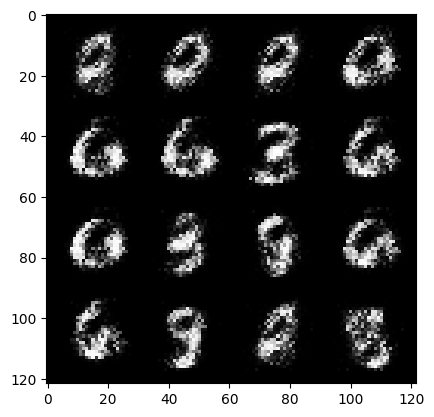

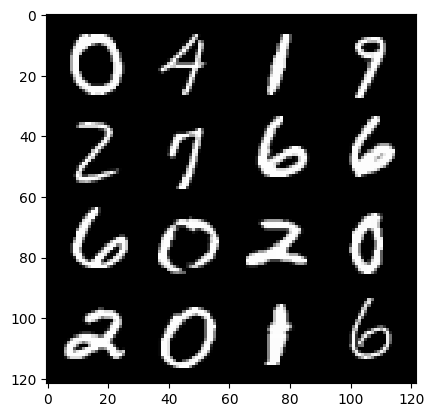

18: step: 8800 | Gen loss: 3.9938605237007136 | Disc loss: 0.05773837331682442


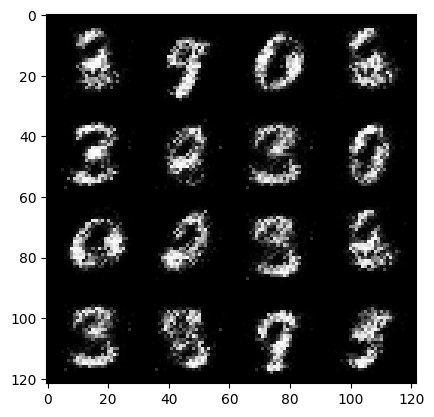

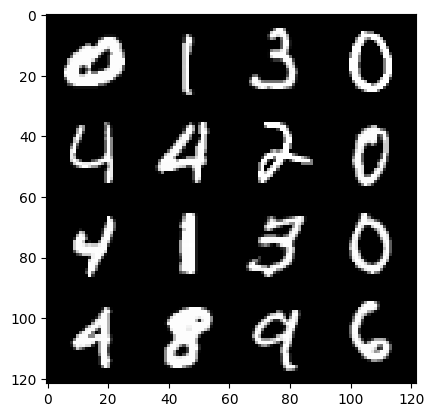

18: step: 8900 | Gen loss: 4.029040451049806 | Disc loss: 0.05800259118899704


  0%|          | 0/469 [00:00<?, ?it/s]

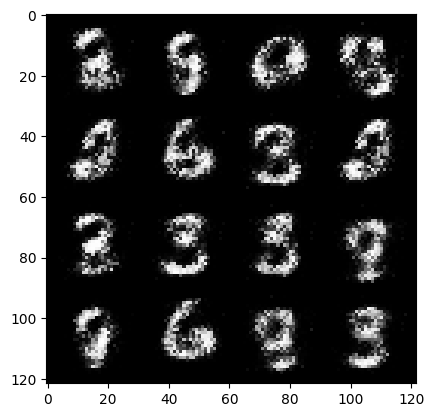

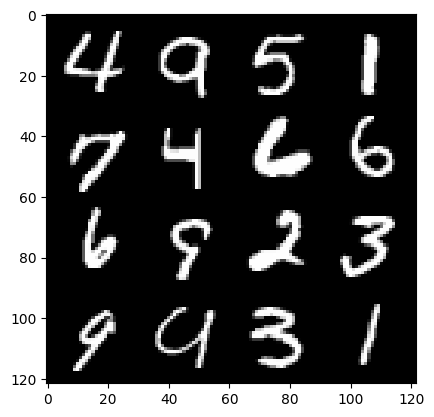

19: step: 9000 | Gen loss: 4.070325450897215 | Disc loss: 0.05817984838038683


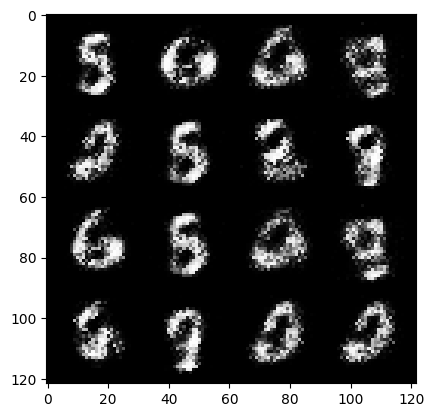

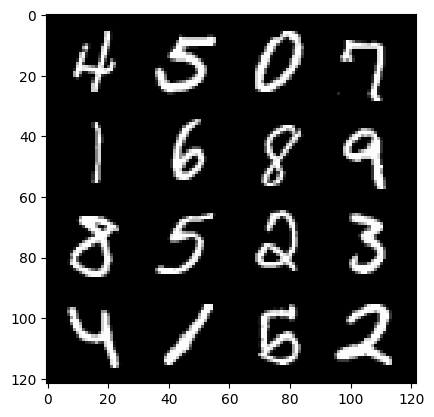

19: step: 9100 | Gen loss: 4.171137084960938 | Disc loss: 0.05587152581661939


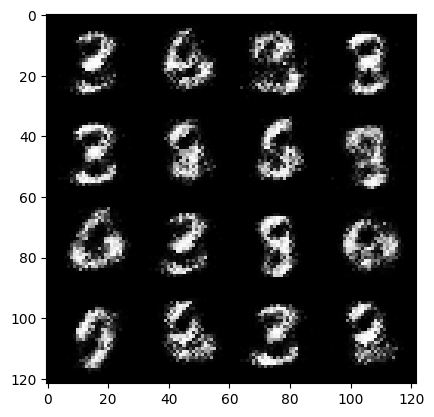

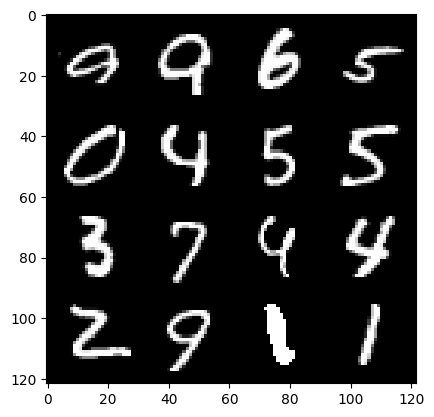

19: step: 9200 | Gen loss: 4.287287664413451 | Disc loss: 0.04961141908541321


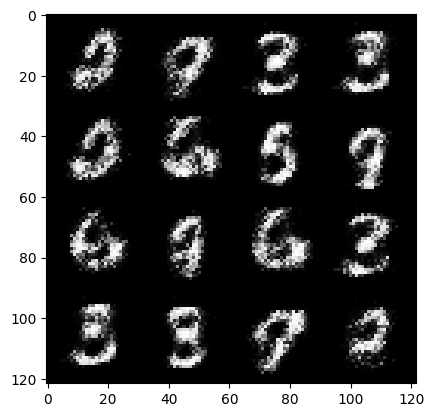

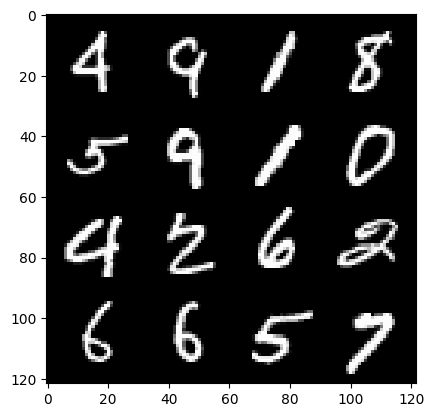

19: step: 9300 | Gen loss: 4.284271836280821 | Disc loss: 0.05095139356330036


In [12]:
for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs = len(real) # 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1)
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_fnc,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward()
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_fnc,gen,disc,cur_bs,z_dim)
    gen_loss.backward()
    gen_opt.step()

    mean_disc_loss += disc_loss.item()/info_step  # item() convert tensor to standalone number
    mean_gen_loss += gen_loss.item()/info_step

    if current_step % info_step == 0 and current_step >0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step: {current_step} | Gen loss: {mean_gen_loss} | Disc loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0,0
    current_step += 1